<hr>

### **Requirements**

In [1]:
pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.4 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import tensorflow as tf
from tensorflow.keras.layers import SimpleRNN, Dropout, Dense, Reshape, LSTM, GRU, Bidirectional
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import keras_tuner as kt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<hr>

### **Data Preparation & Helper Functions**

In [4]:
stock_price_test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Assignment 03/Google_Stock_Price_Test.csv')
stock_price_train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Deep Learning Assignment 03/Google_Stock_Price_Train.csv')

In [5]:
stock_price_test['Date'] = pd.to_datetime(stock_price_test['Date'])
stock_price_train['Date'] = pd.to_datetime(stock_price_train['Date'])
numerical_features = ['Open', 'High', 'Low', 'Close', 'Volume']

for col in numerical_features:
    if stock_price_train[col].dtype == 'object':
        stock_price_train[col] = pd.to_numeric(stock_price_train[col].str.replace(',', ''), errors='raise')

for col in numerical_features:
    if stock_price_test[col].dtype == 'object':
        stock_price_test[col] = pd.to_numeric(stock_price_test[col].str.replace(',', ''), errors='raise')

In [6]:
print(stock_price_test.head())

        Date    Open    High     Low   Close   Volume
0 2017-01-03  778.81  789.63  775.80  786.14  1657300
1 2017-01-04  788.36  791.34  783.16  786.90  1073000
2 2017-01-05  786.08  794.48  785.02  794.02  1335200
3 2017-01-06  795.26  807.90  792.20  806.15  1640200
4 2017-01-09  806.40  809.97  802.83  806.65  1272400


In [7]:
print(stock_price_train.head())

        Date    Open    High     Low   Close    Volume
0 2012-01-03  325.25  332.83  324.97  663.59   7380500
1 2012-01-04  331.27  333.87  329.08  666.45   5749400
2 2012-01-05  329.83  330.75  326.89  657.21   6590300
3 2012-01-06  328.34  328.77  323.68  648.24   5405900
4 2012-01-09  322.04  322.29  309.46  620.76  11688800


In [8]:
test_scaler = MinMaxScaler()
train_scaler = MinMaxScaler()

test_scaled = test_scaler.fit_transform(stock_price_test[numerical_features])
train_scaled = train_scaler.fit_transform(stock_price_train[numerical_features])

In [9]:
days_per_datapoint = 30
training_days = 730 + days_per_datapoint
prediction_time = 3

In [10]:
def create_dataset(dataset, look_back=100, recent_days=100):
    """
    Transforms the dataset from a 2D array into a 3D format compatible with
        RNNs. Assumes data is in the format [samples, features] and
        chronological order.

    Outputs a transformed dataset and a corresponding target tuple,
        maintaining feature dimensions X, y - (day, sliding window, features).

    :param dataset: Dataset to be transformed.
    :param look_back: Number of days to consider each days data when training
    :param recent_days: Number of most recent days to use for training
    """
    dataset = dataset[-recent_days:]

    X, Y = [], []
    for i in range(len(dataset) - look_back):
        a = dataset[i:(i + look_back), :]
        X.append(a)
        Y.append(dataset[i + look_back, :])
    return np.array(X), np.array(Y)

In [11]:
def predict_future(model, recent_data, prediction_time, look_back):
    """
    Predicts future values for a given number of days.

    Outputs a list of predicted values for each day [days[features]].

    :param model: Trained RNN model.
    :param recent_data: Array of shape (look_back, num_features) containing,
        the most recent data points.
    :param prediction_time: Number of days to predict into the future.
    :param look_back: Number of past days the model looks back
        to make a prediction.
    """
    predictions = []

    input_sequence = recent_data.copy()

    for i in range(prediction_time):
        input_sequence_reshaped = np.expand_dims(input_sequence, axis=0)
        next_prediction = model.predict(input_sequence_reshaped, verbose=0)
        predictions.append(next_prediction[0])
        input_sequence = np.vstack((input_sequence[1:], next_prediction))

    return np.array(predictions)

In [12]:
def plot_predictions(true_values, predicted_values, feature_labels):
    """
    Plots feature labels as series predictions against the true values.

    Outputs a 2, 3 sub plot of features

    :param true_values: Array of shape (prediction_time, num_features)
        containing the true values.
    :param predicted_values: Array of shape (prediction_time, num_features)
        containing the predicted values.
    :param feature_labels: List of feature labels to be plotted.
    """
    plt.figure(figsize=(20, 8))

    for i in range(true_values.shape[1]):
        plt.subplot(2, 3, i+1)
        plt.plot(true_values[:, i], label='True '+ numerical_features[i])
        plt.plot(predicted_values[:, i], label='Predicted '+ numerical_features[i])
        plt.title(f'{numerical_features[i]}: True vs Predicted')
        plt.xlabel('Time (Days)')
        plt.ylabel("Value")
        plt.ylabel(numerical_features[i])
        plt.legend()
        plt.grid()

    plt.tight_layout()
    plt.show()

In [13]:
def evaluate_model(true_values, predictions):
    """
    Calculates the mse, rmse, mae, and r2 for a set of predictions against
        the true values.

    Outputs tuple (mse, rmse, mae, r2)

    :param true_values: Array of shape (prediction_time, num_features)
        containing the true values.
    :param predictions: Array of shape (prediction_time, num_features)
        containing the predicted values.
    """
    mse = mean_squared_error(true_values, predictions)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true_values, predictions)
    r2 = r2_score(true_values, predictions)
    return mse, rmse, mae, r2

In [14]:
new_test_set = train_scaled[-prediction_time:]

rescaled_test = train_scaler.inverse_transform(new_test_set)

In [15]:
X_train, y_train = create_dataset(train_scaled, look_back=days_per_datapoint, recent_days=training_days)
X_train = np.array(X_train)
y_train = np.array(y_train)

In [16]:
print(new_test_set)

[[0.95725128 0.95807422 0.95844067 0.40495845 0.04589107]
 [0.93796041 0.94257381 0.95033338 0.40184391 0.02949139]
 [0.93688146 0.93669113 0.93421352 0.38672602 0.07056868]]


<hr>

### **Simple RNN Model**

In [ ]:
def simple_rnn_model(past_days=training_days):
    model = tf.keras.models.Sequential()

    model.add(SimpleRNN(units=past_days, activation='tanh', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(SimpleRNN(units=past_days, activation='tanh', return_sequences=True))
    model.add(Dropout(0.2))

    model.add(SimpleRNN(units=past_days, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=5))
    return model

In [ ]:
simple_model = simple_rnn_model()
simple_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)               │ (None, 760, 760)            │         582,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 760, 760)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_1 (SimpleRNN)             │ (None, 760, 760)            │       1,155,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 760, 760)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ simple_rnn_2 (SimpleRNN)             │ (None, 760)                 │       1,155,960 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 760)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           3,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,897,885 (11.05 MB)

 Trainable params: 2,897,885 (11.05 MB)

 Non-trainable params: 0 (0.00 B)

In [17]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True) # Used for all models

In [ ]:
simple_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
simple_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 359ms/step - loss: 6.6118 - mae: 1.8450 - mape: 600263.4375 - val_loss: 5.3173 - val_mae: 1.8099 - val_mape: 892.3605
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - loss: 2.0341 - mae: 1.0340 - mape: 208421.9219 - val_loss: 0.1208 - val_mae: 0.3118 - val_mape: 146.7017
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.5650 - mae: 0.6004 - mape: 58060.0156 - val_loss: 0.0512 - val_mae: 0.1770 - val_mape: 42.5314
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4624 - mae: 0.5382 - mape: 138816.4844 - val_loss: 0.1142 - val_mae: 0.2837 - val_mape: 49.1022
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.4792 - mae: 0.5473 - mape: 300914.7812 - val_loss: 0.0913 - val_mae: 0.2470 - val_mape: 70.2764
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.4503 - mae: 0.5318 - mape: 669475.1875 - val_loss: 0.1117 - val_mae: 0.2910 - val_mape: 66.6711
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/s

In [ ]:
simple_predictions = predict_future(simple_model, new_test_set, prediction_time, training_days)

print(f"Simple model predicted Future Stock Prices: \n {simple_predictions}")

Simple model predicted Future Stock Prices: 
 [[-0.3478481  -0.45651037 -0.639229   -0.15181981  0.3490069 ]
 [-0.34673515 -0.4649787  -0.63863766 -0.1601464   0.36194718]
 [-0.5773375  -0.6493283  -0.7878036  -0.254646    0.04217846]]


In [ ]:
rescaled_simple_predictions = train_scaler.inverse_transform(simple_predictions)

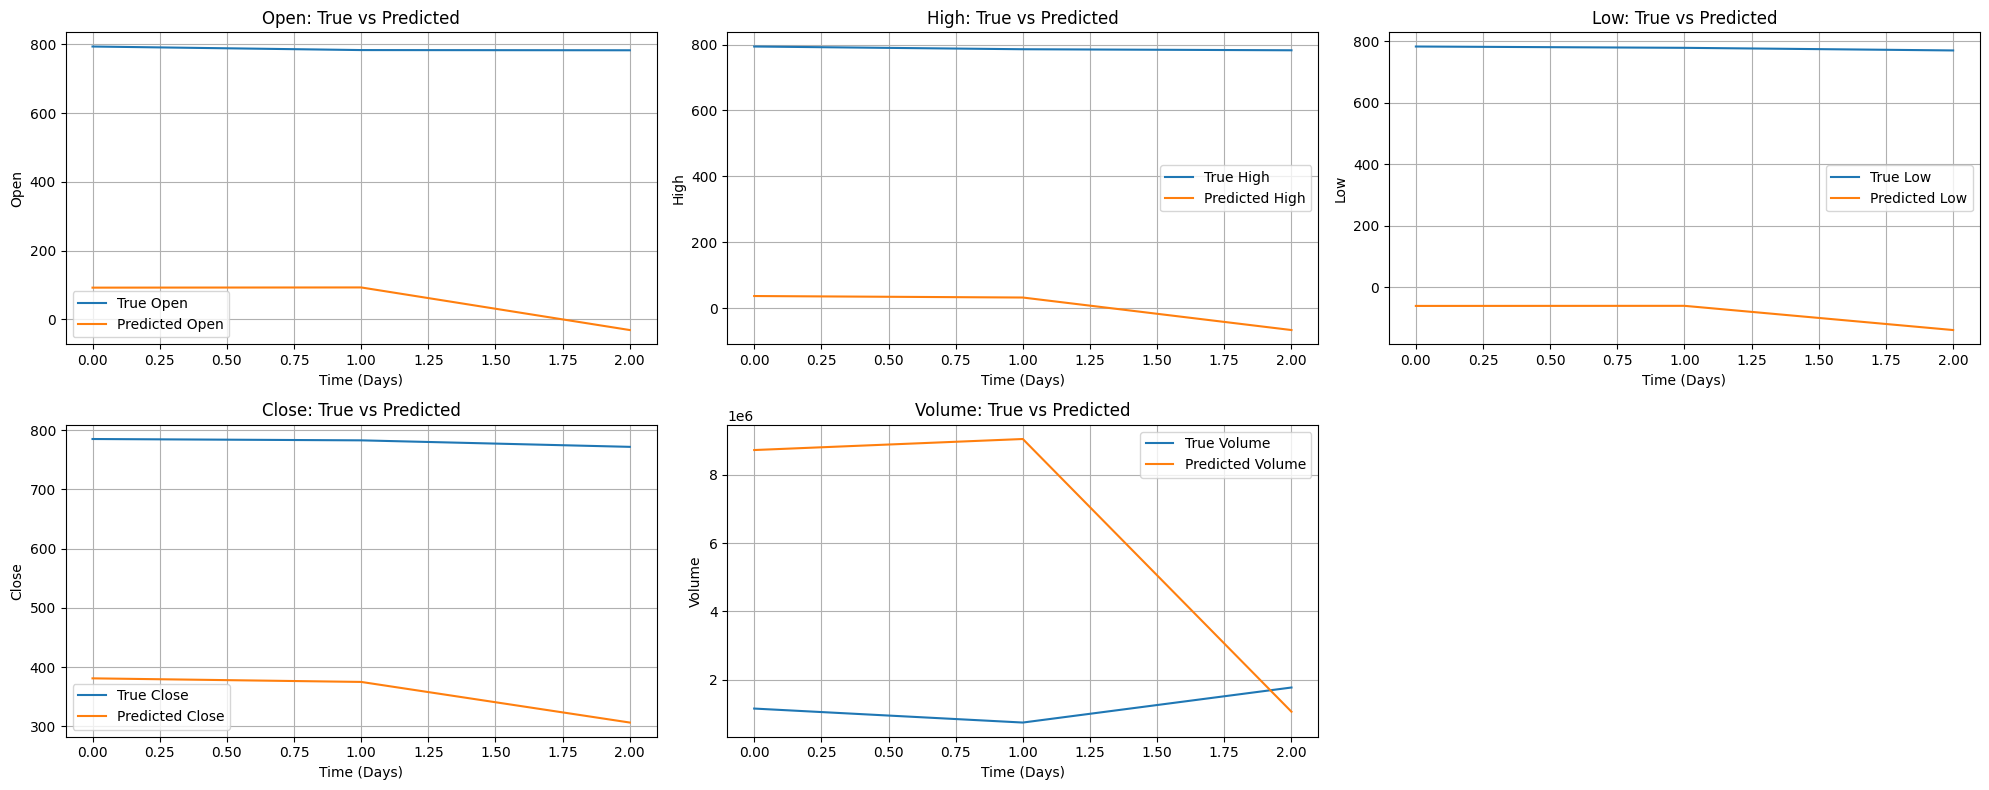

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_simple_predictions, feature_labels=numerical_features)

In [ ]:
simple_mse, simple_rmse, simple_mae, simple_r2 = evaluate_model(new_test_set, simple_predictions)

print(f"Simple MSE: {simple_mse}") # the lower the better, where squaring the errors penalizes larger errors more heavily
print(f"Simple RMSE: {simple_rmse}") # RMSE indicates how much, on average, the model's predictions deviate from the true values. Indicating a % error from normalised data on average
print(f"Simple MAE: {simple_mae}") # The average of the absolute differences between predicted and true values. MAE is less sensitive to large outliers compared to MSE
print(f"Simple R-squared: {simple_r2}") #  Indicates the proportion of variance in the true data captured by the model. Values range from 1 (perfect fit) to 0 (no fit). Negative values indicate the model performs worse than a simple average prediction.

Simple MSE: 1.4284948604422307
Simple RMSE: 1.1951965781586855
Simple MAE: 1.0563287113018638
Simple R-squared: -16048.596641642283


In [ ]:
simple_model.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Assignment 03/simple_model.keras')

<hr>

### **Using an LSTM**

In [ ]:
def simple_lstm_model(past_days=training_days):
    model = tf.keras.models.Sequential()

    model.add(LSTM(units=past_days, activation='tanh', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=past_days, activation='tanh', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(LSTM(units=past_days, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=5))
    return model

In [ ]:
lstm_model = simple_lstm_model()
lstm_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, 760, 760)            │       2,328,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 760, 760)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 760, 760)            │       4,623,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 760, 760)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 760)                 │       4,623,840 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 760)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           3,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 11,580,125 (44.17 MB)

 Trainable params: 11,580,125 (44.17 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
lstm_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 8s 67ms/step - loss: 0.1482 - mae: 0.2840 - mape: 323950.5000 - val_loss: 0.0308 - val_mae: 0.1612 - val_mape: 42.7986
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0113 - mae: 0.0757 - mape: 120244.4219 - val_loss: 0.0039 - val_mae: 0.0510 - val_mape: 14.8181
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step - loss: 0.0058 - mae: 0.0507 - mape: 15700.9980 - val_loss: 0.0017 - val_mae: 0.0348 - val_mape: 20.5730
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - loss: 0.0044 - mae: 0.0415 - mape: 38214.7461 - val_loss: 0.0014 - val_mae: 0.0306 - val_mape: 20.5526
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0034 - mae: 0.0388 - mape: 39504.1641 - val_loss: 0.0012 - val_mae: 0.0288 - val_mape: 15.5659
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0037 - mae: 0.0410 - mape: 118492.8125 - val_loss: 0.0038 - val_mae: 0.0536 - val_mape: 22.2414
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - l

In [ ]:
lstm_model_predictions = predict_future(lstm_model, new_test_set, prediction_time, training_days)

print(f"LSTM model predicted Future Stock Prices: \n {lstm_model_predictions}")

LSTM model predicted Future Stock Prices: 
 [[0.69853467 0.69903225 0.7091769  0.5271668  0.10200432]
 [0.6637056  0.6638198  0.6744528  0.5339878  0.10080104]
 [0.6064208  0.6062585  0.61716425 0.5495572  0.09871759]]


In [ ]:
rescaled_lstm_predictions = train_scaler.inverse_transform(lstm_model_predictions)

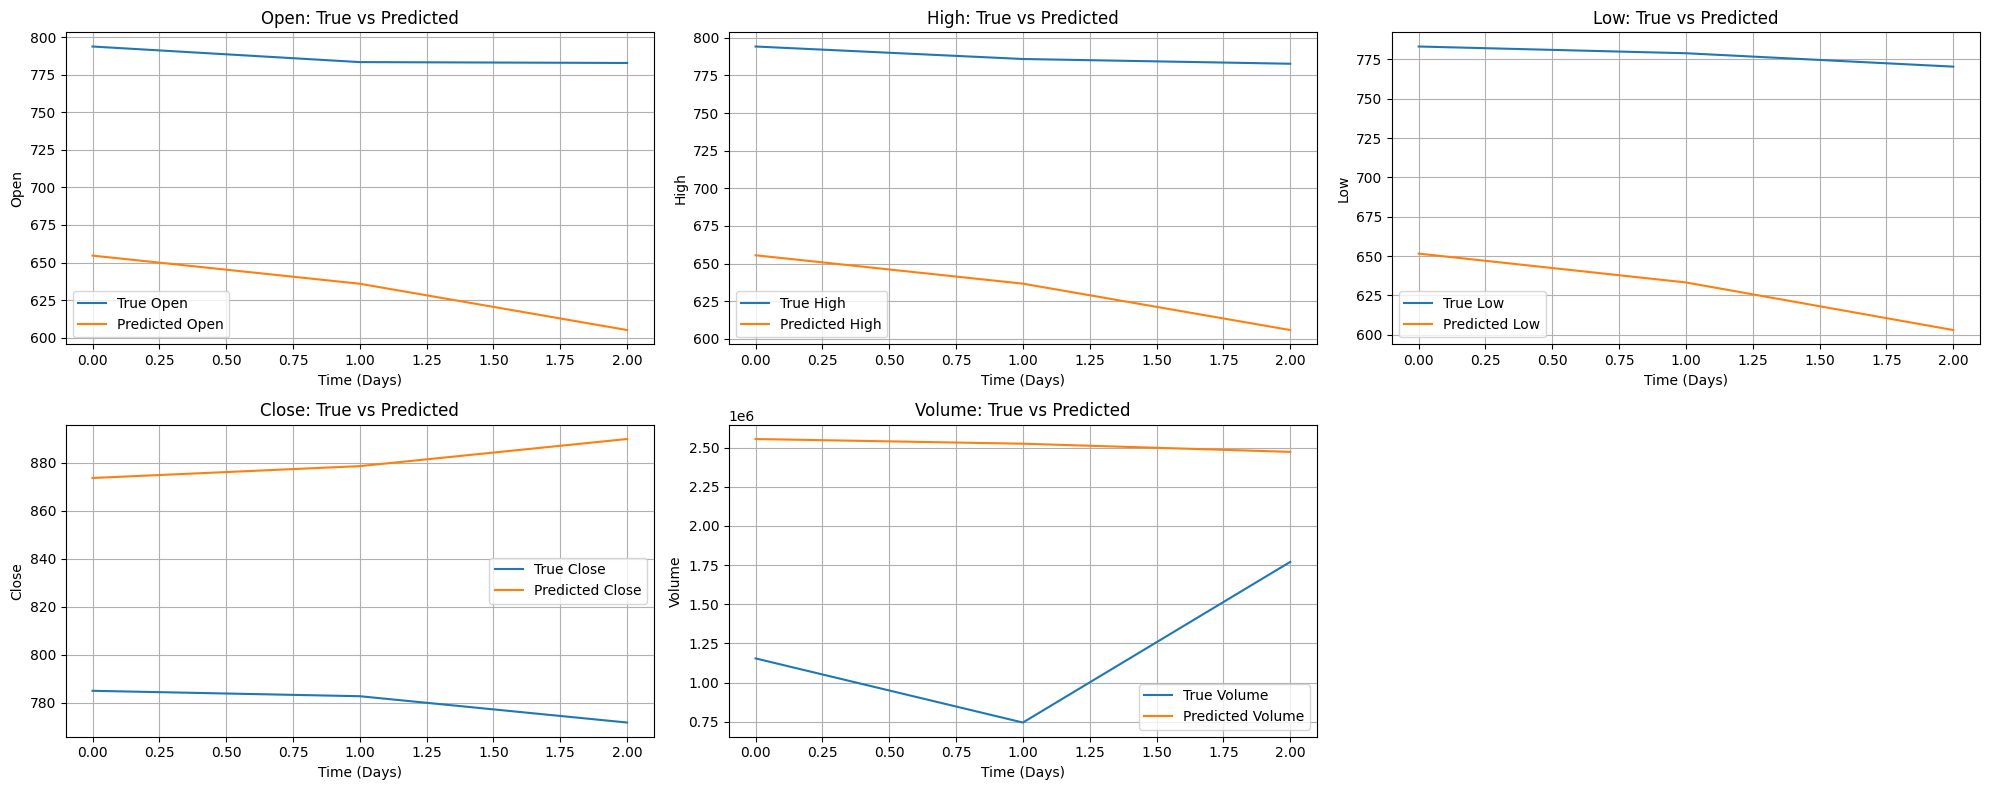

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_lstm_predictions, feature_labels=numerical_features)

In [ ]:
lstm_mse, lstm_rmse, lstm_mae, lstm_r2 = evaluate_model(new_test_set, lstm_model_predictions)

print(f"LSTM MSE: {lstm_mse}")
print(f"LSTM RMSE: {lstm_rmse}")
print(f"LSTM MAE: {lstm_mae}")
print(f"LSTM R-squared: {lstm_r2}")

LSTM MSE: 0.05413641883996373
LSTM RMSE: 0.23267234223251315
LSTM MAE: 0.20977397253283203
LSTM R-squared: -619.5293887547022


In [ ]:
lstm_model.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Assignment 03/lstm_model.keras')

<hr>

### **USing GRU**

In [ ]:
def simple_gru_model(past_days=training_days):
    model = tf.keras.models.Sequential()

    model.add(GRU(units=past_days, activation='tanh', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='tanh', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=5))
    return model

In [ ]:
gru_model = simple_gru_model()
gru_model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ gru (GRU)                            │ (None, 760, 760)            │       1,748,760 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 760, 760)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_1 (GRU)                          │ (None, 760, 760)            │       3,470,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 760, 760)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ gru_2 (GRU)                          │ (None, 760)                 │       3,470,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 760)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 5)                   │           3,805 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,692,885 (33.16 MB)

 Trainable params: 8,692,885 (33.16 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
gru_model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
gru_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step - loss: 0.1012 - mae: 0.2300 - mape: 7806.7822 - val_loss: 0.0099 - val_mae: 0.0783 - val_mape: 16.0355
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0052 - mae: 0.0520 - mape: 5048.9629 - val_loss: 0.0013 - val_mae: 0.0313 - val_mape: 18.2655
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0033 - mae: 0.0399 - mape: 11260.9072 - val_loss: 0.0024 - val_mae: 0.0400 - val_mape: 30.4359
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0027 - mae: 0.0367 - mape: 9139.7881 - val_loss: 4.7276e-04 - val_mae: 0.0167 - val_mape: 11.0813
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0021 - mae: 0.0319 - mape: 14472.4238 - val_loss: 0.0019 - val_mae: 0.0351 - val_mape: 13.9622
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.0030 - mae: 0.0378 - mape: 72856.4297 - val_loss: 8.9770e-04 - val_mae: 0.0235 - val_mape: 13.9421
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step -

In [ ]:
gru_model_predictions = predict_future(gru_model, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {gru_model_predictions}")

GRU model predicted Future Stock Prices: 
 [[0.8393349  0.84281814 0.84584004 0.43118832 0.0541843 ]
 [0.795839   0.8015726  0.80288845 0.43080744 0.05674076]
 [0.7492227  0.75454295 0.75627965 0.43666017 0.06104641]]


In [ ]:
rescaled_gru_predictions = train_scaler.inverse_transform(gru_model_predictions)

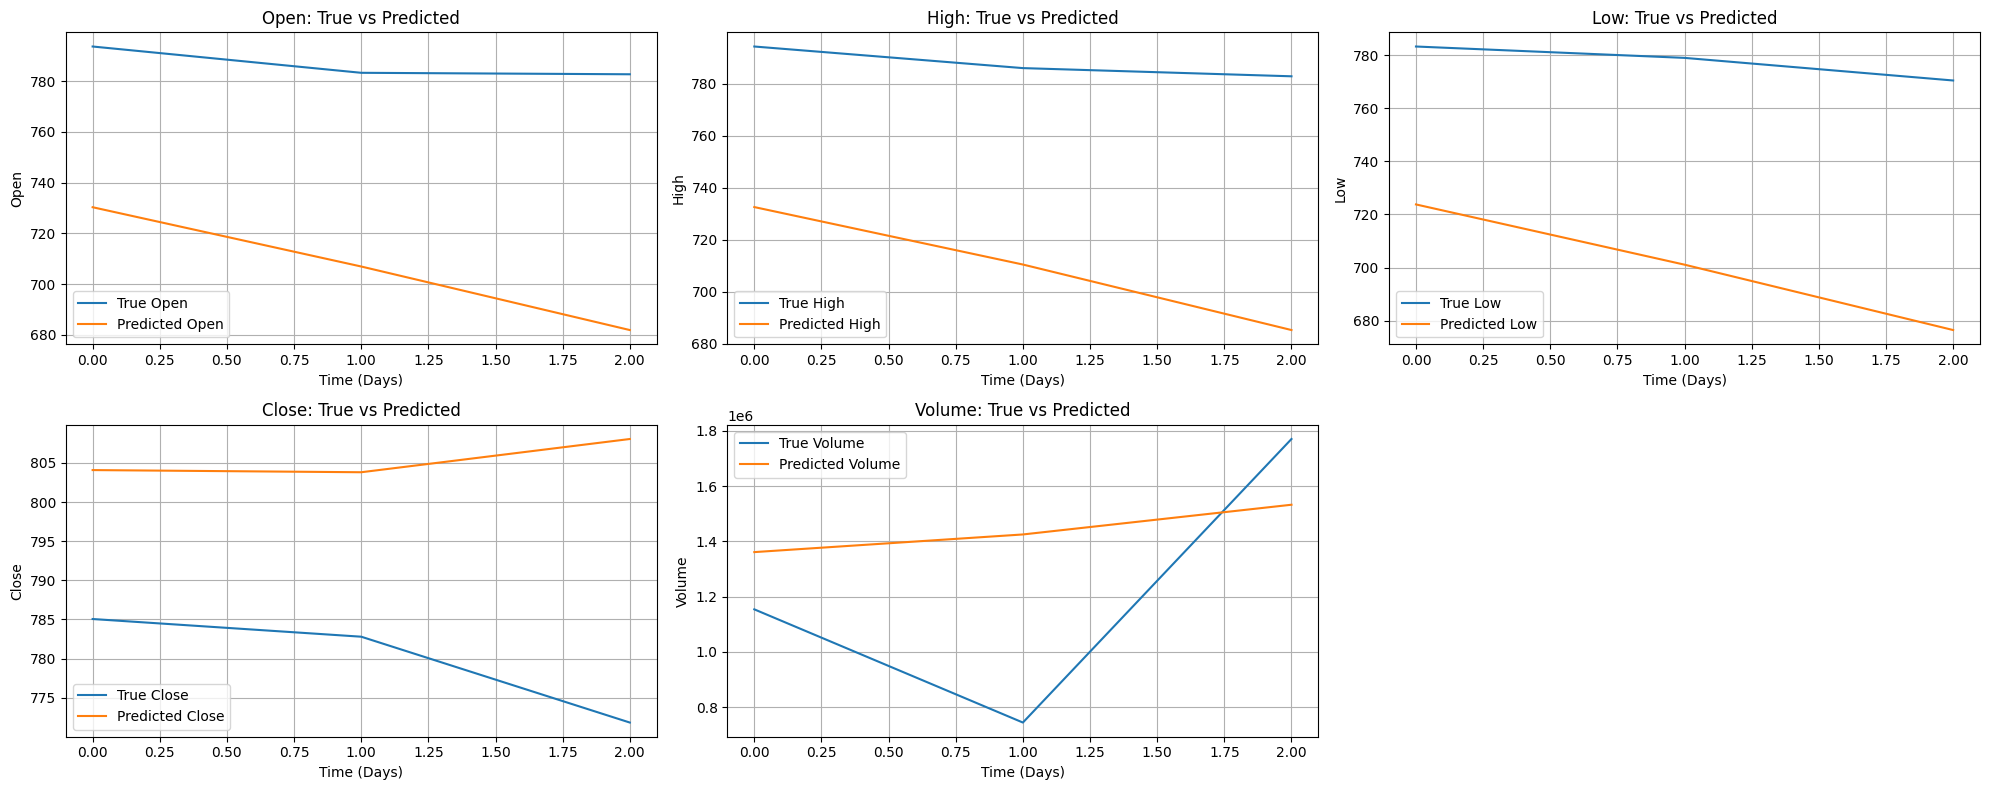

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_gru_predictions, feature_labels=numerical_features)

In [ ]:
gru_mse, gru_rmse, gru_mae, gru_r2 = evaluate_model(new_test_set, gru_model_predictions)

print(f"GRU MSE: {gru_mse}")
print(f"GRU RMSE: {gru_rmse}")
print(f"GRU MAE: {gru_mae}")
print(f"GRU R-squared: {gru_r2}")

GRU MSE: 0.013777566833965629
GRU RMSE: 0.11737788051402882
GRU MAE: 0.09828492365668422
GRU R-squared: -154.0228487707246


In [ ]:
gru_model.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Assignment 03/gru_model.keras')

<hr>

### **GRU Feature Addition Study**


In [ ]:
def increased_complexity_gru_01(past_days=training_days):
    model = tf.keras.models.Sequential()

    model.add(GRU(units=past_days, activation='relu', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_01 = increased_complexity_gru_01()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_01.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_01.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 15s 424ms/step - loss: 0.1893 - mae: 0.3277 - mape: 6964.2598 - val_loss: 0.1273 - val_mae: 0.3055 - val_mape: 47.1385
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0327 - mae: 0.1371 - mape: 17189.7832 - val_loss: 0.0102 - val_mae: 0.0944 - val_mape: 37.1794
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0111 - mae: 0.0737 - mape: 44251.9883 - val_loss: 0.0054 - val_mae: 0.0680 - val_mape: 35.5670
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0072 - mae: 0.0623 - mape: 65244.5859 - val_loss: 0.0022 - val_mae: 0.0411 - val_mape: 27.5409
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0043 - mae: 0.0490 - mape: 72190.7188 - val_loss: 0.0035 - val_mae: 0.0531 - val_mape: 35.0662
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - loss: 0.0037 - mae: 0.0426 - mape: 27536.0703 - val_loss: 0.0015 - val_mae: 0.0317 - val_mape: 16.4359
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 66ms/step - los

In [ ]:
improved_gru_predictions_01 = predict_future(improved_gru_01, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_01}")

GRU model predicted Future Stock Prices: 
 [[0.25122306 0.22074829 0.2122658  0.10455362 0.01376073]
 [0.22712296 0.19940239 0.19223793 0.09486715 0.01289892]
 [0.1866009  0.16403447 0.15850347 0.07816707 0.01103117]]


In [ ]:
rescaled_improved_gru_predictions_01 = train_scaler.inverse_transform(improved_gru_predictions_01)

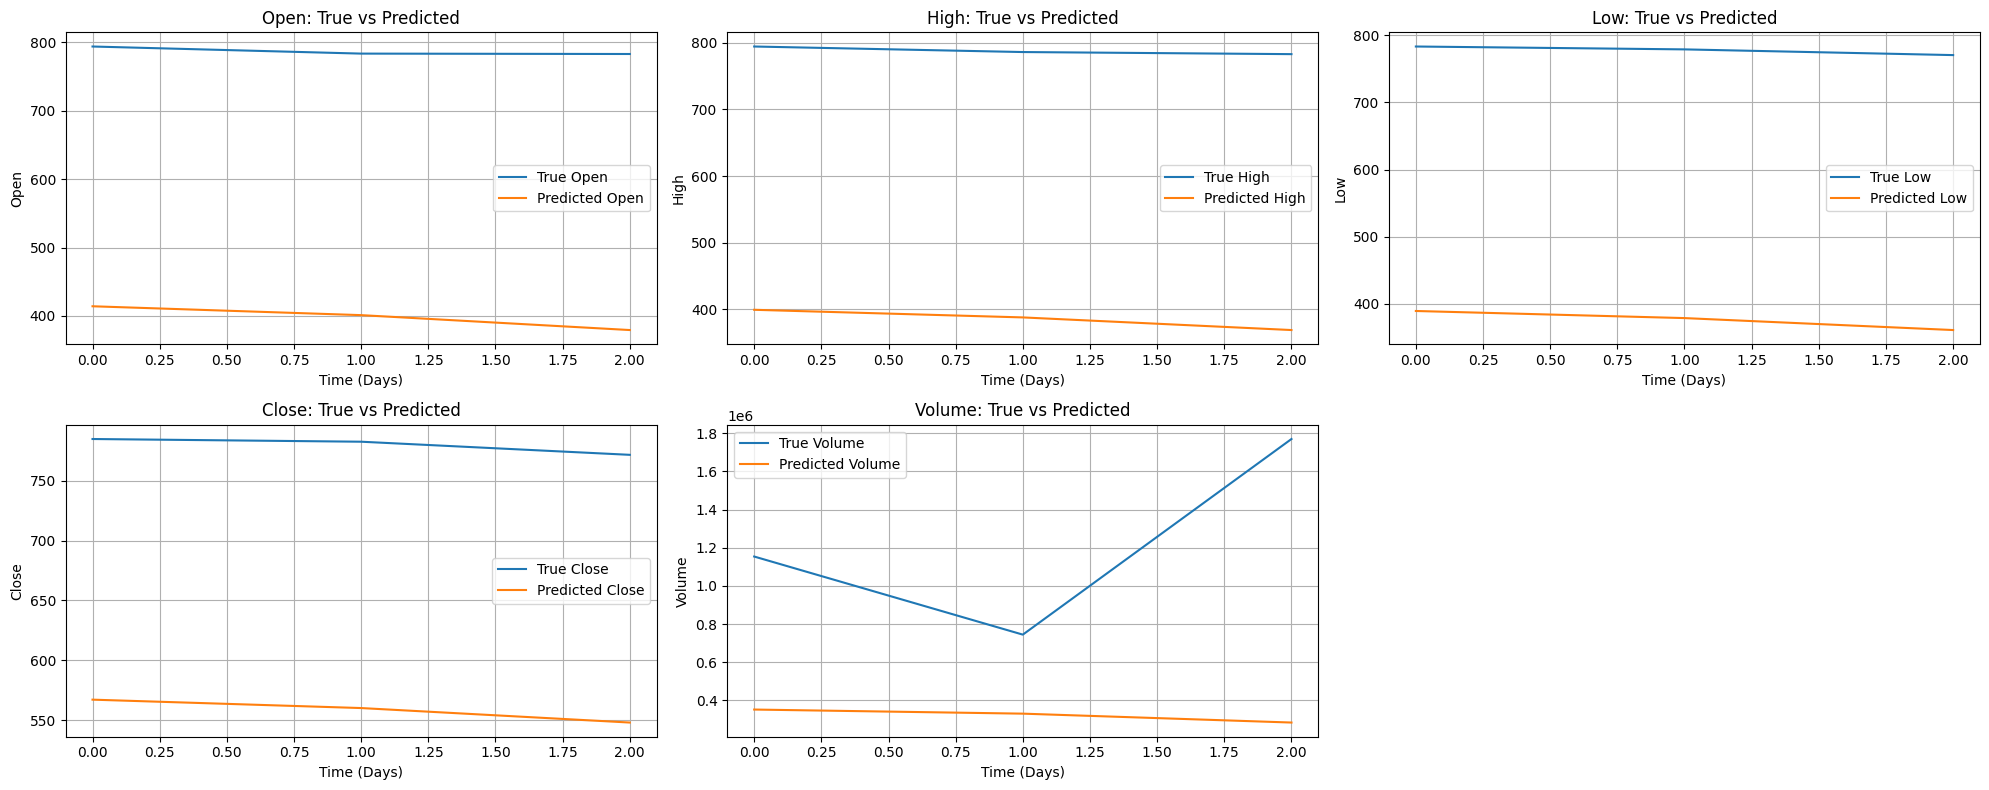

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_01, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_01)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.35182592001642254
Improved GRU RMSE: 0.5931491549487553
Improved GRU MAE: 0.5149654321493726
Improved GRU r^2: -4013.824470409785


<hr>

### Feature Addition Study 02

In [ ]:
def increased_complexity_gru_02(past_days=training_days):
    model = tf.keras.models.Sequential()

    model.add(Bidirectional(GRU(units=past_days, activation='relu', return_sequences=True, input_shape=(past_days, 5))))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_02 = increased_complexity_gru_02()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_02.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_02.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 23s 562ms/step - loss: 0.0861 - mae: 0.2125 - mape: 33382.1641 - val_loss: 0.0018 - val_mae: 0.0362 - val_mape: 25.0412
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 7s 90ms/step - loss: 0.0078 - mae: 0.0648 - mape: 29647.6289 - val_loss: 0.0063 - val_mae: 0.0746 - val_mape: 31.4161
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 99ms/step - loss: 0.0040 - mae: 0.0440 - mape: 25534.7852 - val_loss: 0.0019 - val_mae: 0.0389 - val_mape: 25.7205
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.0029 - mae: 0.0390 - mape: 32642.4121 - val_loss: 0.0012 - val_mae: 0.0289 - val_mape: 16.4160
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0029 - mae: 0.0389 - mape: 12817.9980 - val_loss: 0.0028 - val_mae: 0.0449 - val_mape: 35.3823
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 92ms/step - loss: 0.0030 - mae: 0.0396 - mape: 161353.1562 - val_loss: 6.8573e-04 - val_mae: 0.0200 - val_mape: 18.3377
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 87ms/step

In [ ]:
improved_gru_predictions_02 = predict_future(improved_gru_02, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_02}")

GRU model predicted Future Stock Prices: 
 [[0.49473098 0.5024653  0.48860192 0.17913856 0.06668179]
 [0.4317314  0.4384229  0.4262493  0.15408668 0.0581027 ]
 [0.3533665  0.3586783  0.34895676 0.12271111 0.04772359]]


In [ ]:
rescaled_improved_gru_predictions_02 = train_scaler.inverse_transform(improved_gru_predictions_02)

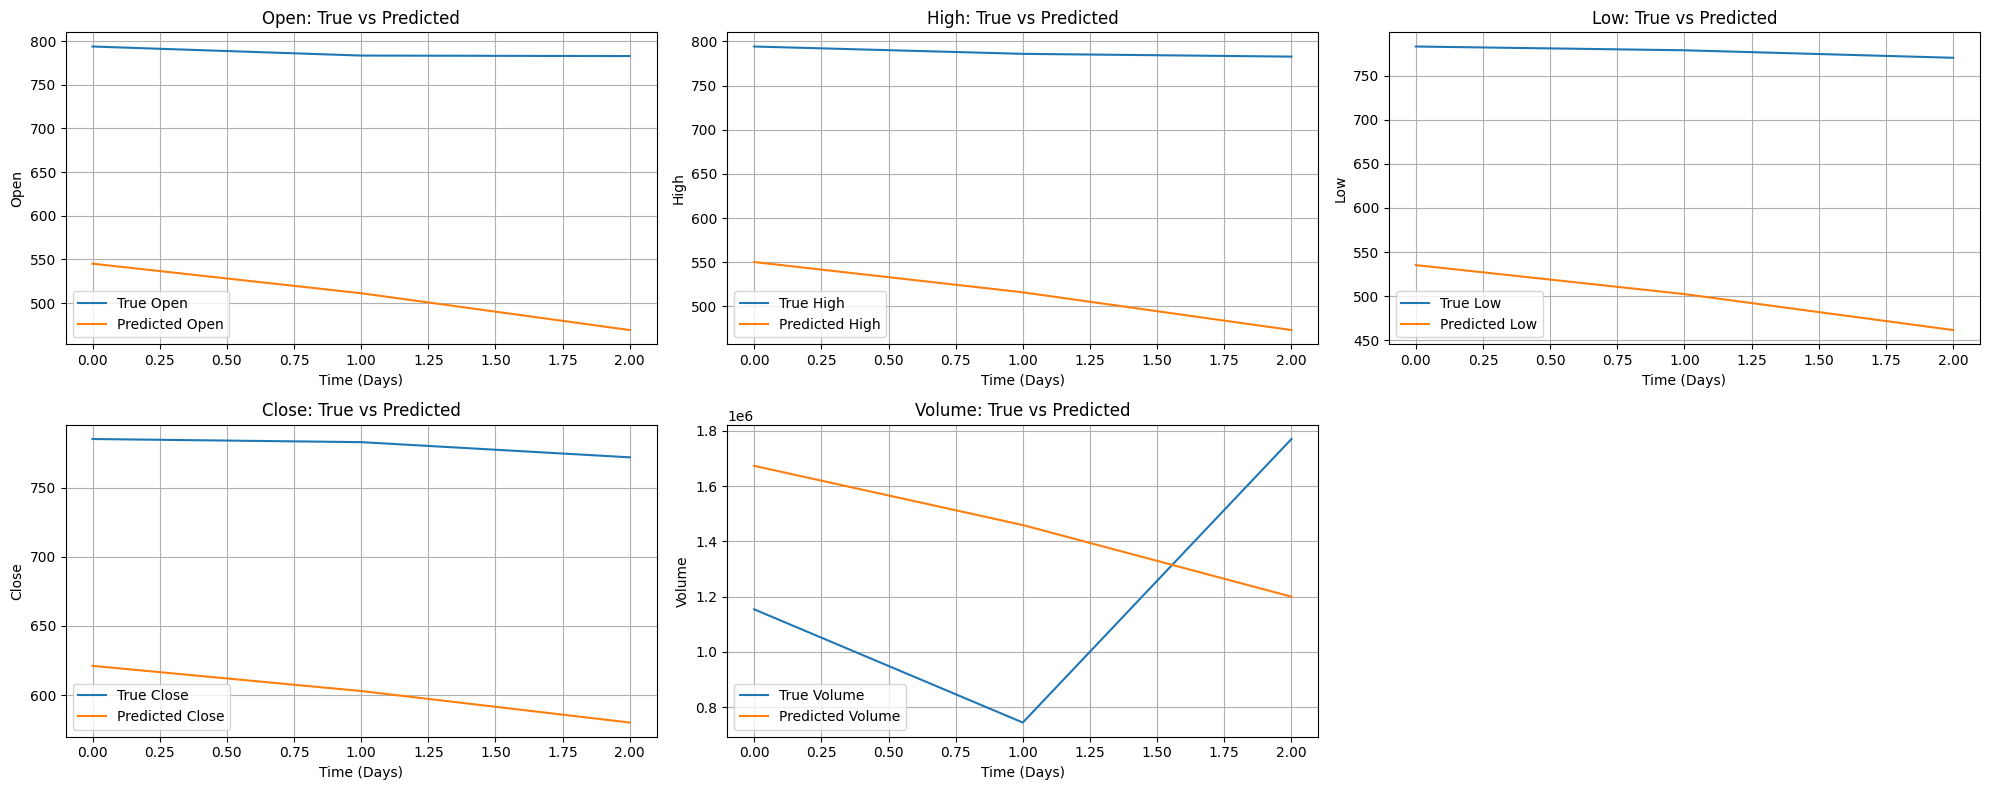

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_02, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_02)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.17522146469804606
Improved GRU RMSE: 0.41859463051745666
Improved GRU MAE: 0.36527037957388214
Improved GRU r^2: -2011.1366740268288


<hr>

### Feature Addition Study 03

In [ ]:
def increased_complexity_gru_03(past_days=training_days, lambda_reg=0.005):
    model = tf.keras.models.Sequential()

    model.add(Bidirectional(GRU(units=past_days, activation='relu', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5))))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', kernel_regularizer=l2(lambda_reg), return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_03 = increased_complexity_gru_03()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_03.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_03.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 31s 949ms/step - loss: 11.1508 - mae: 0.2650 - mape: 21922.4883 - val_loss: 3.0911 - val_mae: 0.0790 - val_mape: 21.6055
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 20s 95ms/step - loss: 2.1139 - mae: 0.0867 - mape: 70050.4453 - val_loss: 0.4632 - val_mae: 0.1158 - val_mape: 21.1434
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.3302 - mae: 0.0672 - mape: 178669.6719 - val_loss: 0.1282 - val_mae: 0.0734 - val_mape: 24.0895
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.1126 - mae: 0.0638 - mape: 127209.6484 - val_loss: 0.0595 - val_mae: 0.0445 - val_mape: 21.2210
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0583 - mae: 0.0577 - mape: 120838.0156 - val_loss: 0.0323 - val_mae: 0.0408 - val_mape: 26.0052
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 88ms/step - loss: 0.0360 - mae: 0.0538 - mape: 60341.2266 - val_loss: 0.0221 - val_mae: 0.0489 - val_mape: 27.9264
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 99ms/step

In [ ]:
improved_gru_predictions_03 = predict_future(improved_gru_03, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_03}")

GRU model predicted Future Stock Prices: 
 [[0.379454   0.3950339  0.4043757  0.16362786 0.01905667]
 [0.33313042 0.3462818  0.35380167 0.14124668 0.01938896]
 [0.27484342 0.28453916 0.28977716 0.11358547 0.01955992]]


In [ ]:
rescaled_improved_gru_predictions_03 = train_scaler.inverse_transform(improved_gru_predictions_03)

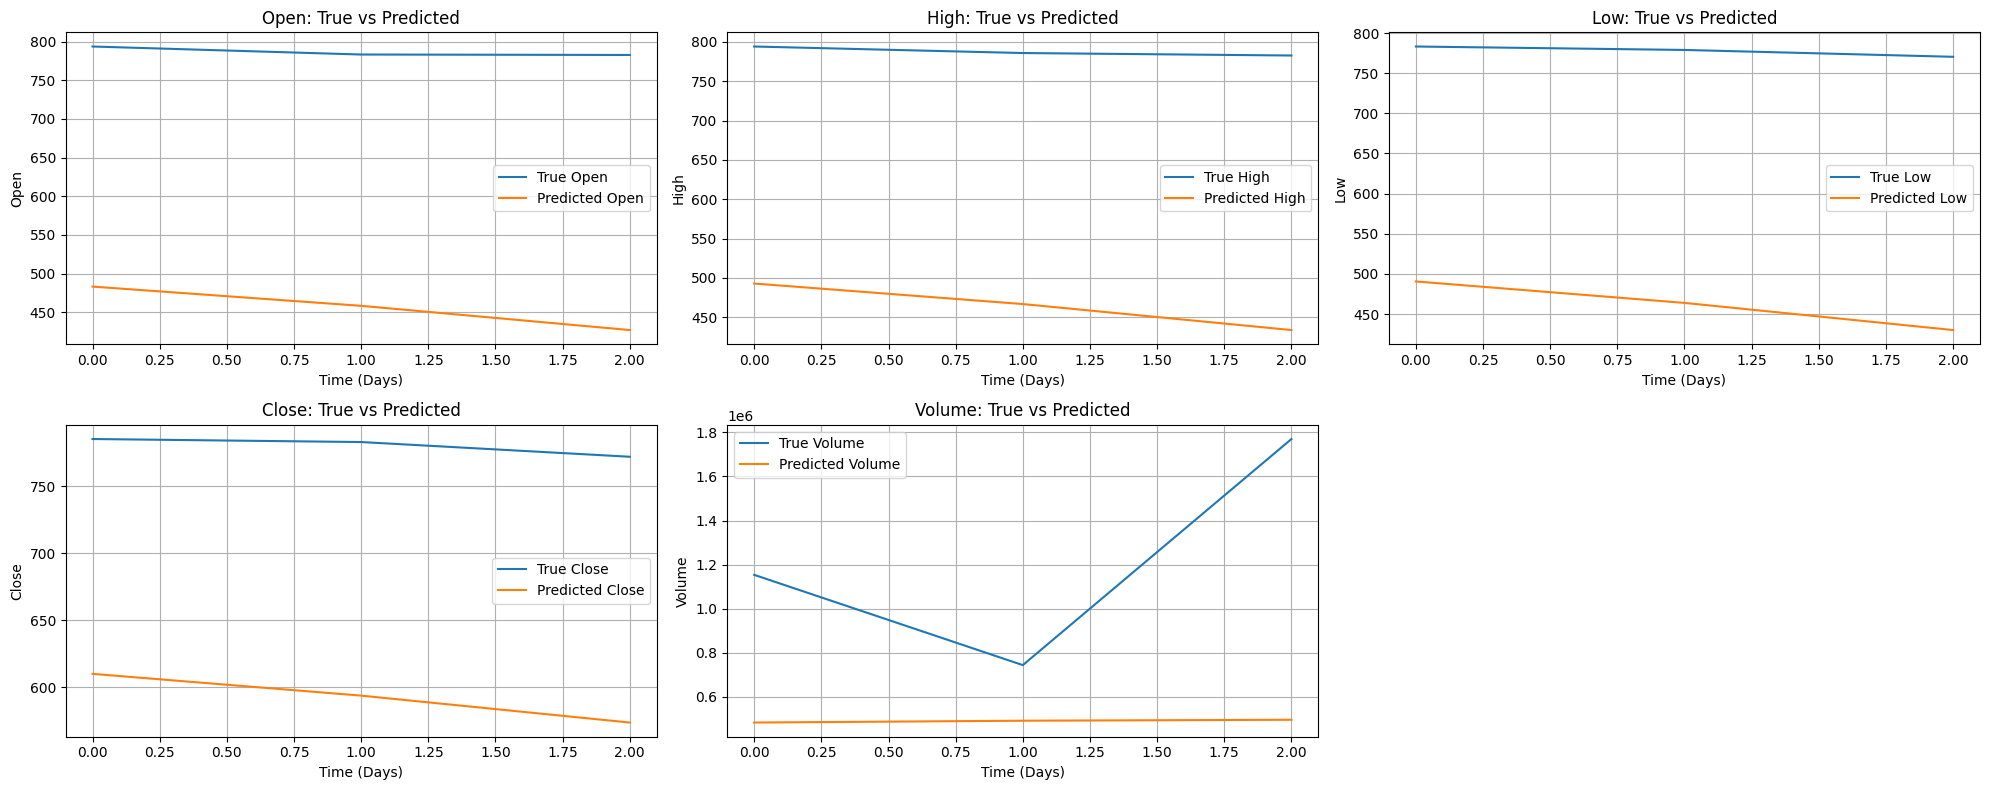

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_03, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_03)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.23454410878203621
Improved GRU RMSE: 0.4842975415816564
Improved GRU MAE: 0.42094644272049486
Improved GRU r^2: -2685.749593242148


<hr>

### Feature Addition Study 04

In [ ]:
def increased_complexity_gru_04(past_days=training_days, lambda_reg=0.005):
    model = tf.keras.models.Sequential()

    model.add(Bidirectional(GRU(units=past_days, activation='relu', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5))))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', kernel_regularizer=l2(lambda_reg), return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=max(10, int(0.5*past_days))))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_04 = increased_complexity_gru_04()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_04.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_04.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 22s 541ms/step - loss: 11.1271 - mae: 0.2331 - mape: 195073.3906 - val_loss: 3.0452 - val_mae: 0.0816 - val_mape: 24.0275
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 94ms/step - loss: 2.0567 - mae: 0.0770 - mape: 46847.7188 - val_loss: 0.4054 - val_mae: 0.1094 - val_mape: 27.7403
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 93ms/step - loss: 0.2761 - mae: 0.0605 - mape: 98506.2812 - val_loss: 0.0911 - val_mae: 0.0714 - val_mape: 27.8336
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - loss: 0.0768 - mae: 0.0568 - mape: 49161.2695 - val_loss: 0.0442 - val_mae: 0.0827 - val_mape: 22.3473
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 89ms/step - loss: 0.0376 - mae: 0.0524 - mape: 31557.9062 - val_loss: 0.0193 - val_mae: 0.0339 - val_mape: 21.1690
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - loss: 20322.5957 - mae: 7.9824 - mape: 77429.3359 - val_loss: 0.4344 - val_mae: 0.1843 - val_mape: 44.6485
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/ste

In [ ]:
improved_gru_predictions_04 = predict_future(improved_gru_04, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_04}")

GRU model predicted Future Stock Prices: 
 [[0.4908542  0.5083484  0.5200156  0.21730852 0.06134063]
 [0.44971347 0.46485627 0.47785228 0.19376826 0.05742149]
 [0.3999917  0.41256526 0.42701262 0.16493876 0.05263594]]


In [ ]:
rescaled_improved_gru_predictions_04 = train_scaler.inverse_transform(improved_gru_predictions_04)

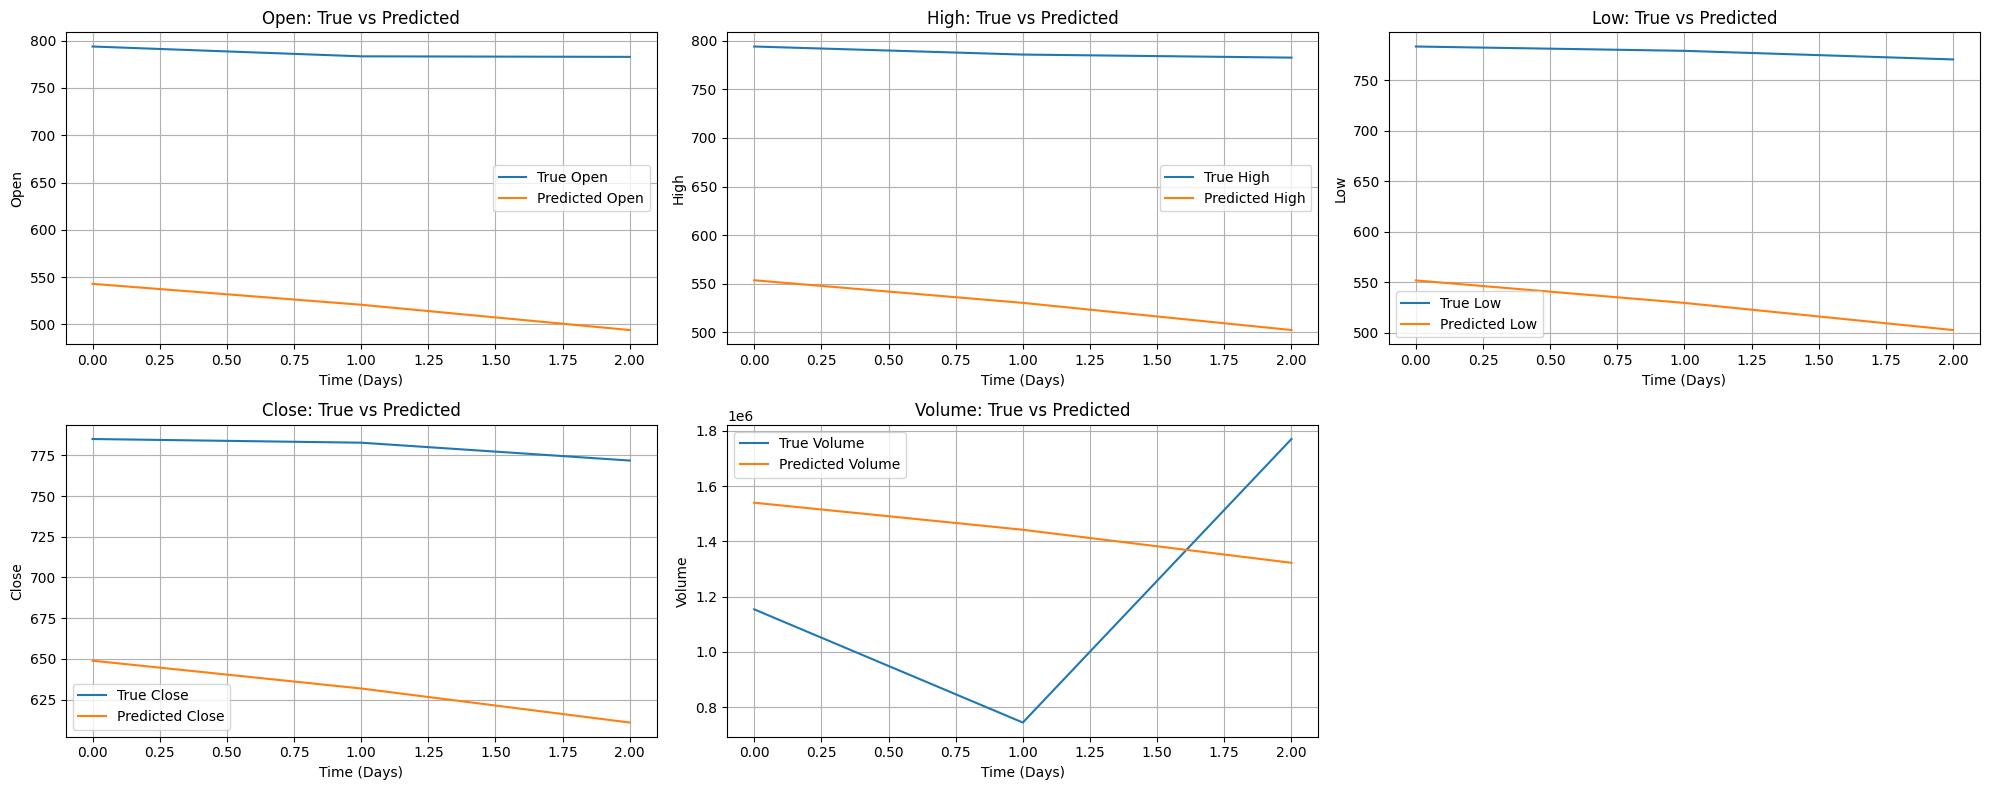

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_04, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_04)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.15007218901771952
Improved GRU RMSE: 0.3873915190317407
Improved GRU MAE: 0.33600235545712753
Improved GRU r^2: -1720.2700798622532


<hr>

### Feature Addition Study 05

In [ ]:
def increased_complexity_gru_05(past_days=training_days, lambda_reg=0.005):
    model = tf.keras.models.Sequential()

    model.add(Bidirectional(GRU(units=int(1.5*past_days), activation='relu', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5))))
    model.add(Dropout(0.2))

    model.add(GRU(units=int(1.25*past_days), activation='relu', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', kernel_regularizer=l2(lambda_reg), return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=max(10, int(0.5*past_days))))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_05 = increased_complexity_gru_05()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_05.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_05.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 28s 599ms/step - loss: 14.1578 - mae: 0.3200 - mape: 14730.3789 - val_loss: 3.4501 - val_mae: 0.2398 - val_mape: 64.4759
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 154ms/step - loss: 2.2997 - mae: 0.0999 - mape: 42654.5938 - val_loss: 0.6030 - val_mae: 0.1386 - val_mape: 31.6568
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 147ms/step - loss: 0.4715 - mae: 0.0810 - mape: 42036.2500 - val_loss: 0.2461 - val_mae: 0.0765 - val_mape: 25.1062
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 146ms/step - loss: 0.2147 - mae: 0.0658 - mape: 35632.3516 - val_loss: 0.1279 - val_mae: 0.0655 - val_mape: 33.3146
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 5s 154ms/step - loss: 0.1171 - mae: 0.0603 - mape: 25936.3301 - val_loss: 0.0785 - val_mae: 0.0793 - val_mape: 32.8651
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 148ms/step - loss: 0.0725 - mae: 0.0562 - mape: 34279.4609 - val_loss: 0.0493 - val_mae: 0.0637 - val_mape: 24.5985
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 146ms/st

In [ ]:
improved_gru_predictions_05 = predict_future(improved_gru_05, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_05}")

GRU model predicted Future Stock Prices: 
 [[0.37335527 0.3650346  0.3990164  0.10509794 0.07585206]
 [0.345753   0.33647153 0.36776853 0.09482163 0.07005438]
 [0.31092402 0.3003019  0.32870045 0.0818117  0.0619176 ]]


In [ ]:
rescaled_improved_gru_predictions_05 = train_scaler.inverse_transform(improved_gru_predictions_05)

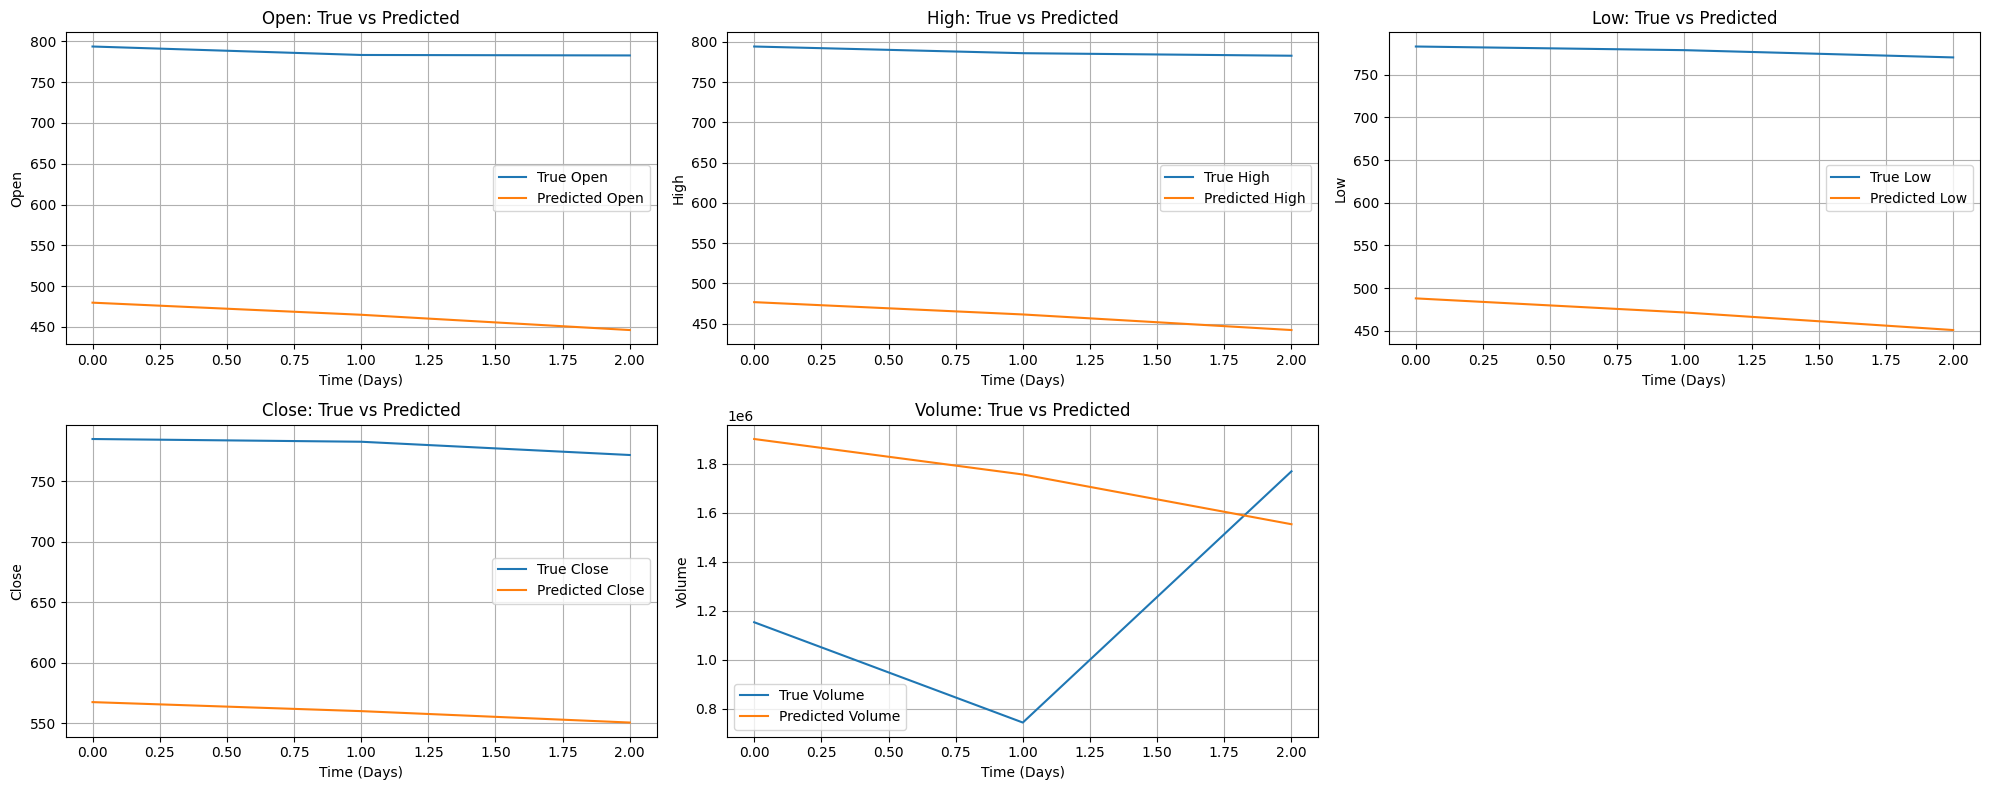

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_05, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_05)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.2337511377846598
Improved GRU RMSE: 0.48347816681279393
Improved GRU MAE: 0.42507108786779685
Improved GRU r^2: -2706.950165858804


<hr>

### Feature Addition Study 06

In [ ]:
def increased_complexity_gru_06(past_days=training_days, lambda_reg=0.005):
    model = tf.keras.models.Sequential()

    model.add(GRU(units=past_days, activation='tanh', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='tanh', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='tanh', return_sequences=False, kernel_regularizer=l2(lambda_reg)))
    model.add(Dropout(0.2))

    model.add(Dense(units=max(10, int(0.5*past_days))))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_06 = increased_complexity_gru_06()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_06.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_06.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 60ms/step - loss: 9.0279 - mae: 0.2389 - mape: 181245.8906 - val_loss: 3.1997 - val_mae: 0.1117 - val_mape: 78.4404
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 2.3054 - mae: 0.0617 - mape: 28178.0566 - val_loss: 0.6333 - val_mae: 0.0727 - val_mape: 45.1012
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.4508 - mae: 0.0496 - mape: 32117.3711 - val_loss: 0.1478 - val_mae: 0.0970 - val_mape: 28.6814
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step - loss: 0.1099 - mae: 0.0510 - mape: 11432.2109 - val_loss: 0.0472 - val_mae: 0.0491 - val_mape: 19.1145
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step - loss: 0.0410 - mae: 0.0448 - mape: 20458.8145 - val_loss: 0.0234 - val_mae: 0.0580 - val_mape: 24.8891
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.0206 - mae: 0.0404 - mape: 68728.3750 - val_loss: 0.0181 - val_mae: 0.0769 - val_mape: 23.3590
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - los

In [ ]:
improved_gru_predictions_06 = predict_future(improved_gru_06, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_06}")

GRU model predicted Future Stock Prices: 
 [[0.6626531  0.531704   0.5803267  0.19491619 0.15960775]
 [0.6050525  0.48582777 0.5309931  0.1712057  0.14684445]
 [0.52477366 0.42248902 0.46212465 0.13762173 0.12988544]]


In [ ]:
rescaled_improved_gru_predictions_06 = train_scaler.inverse_transform(improved_gru_predictions_06)

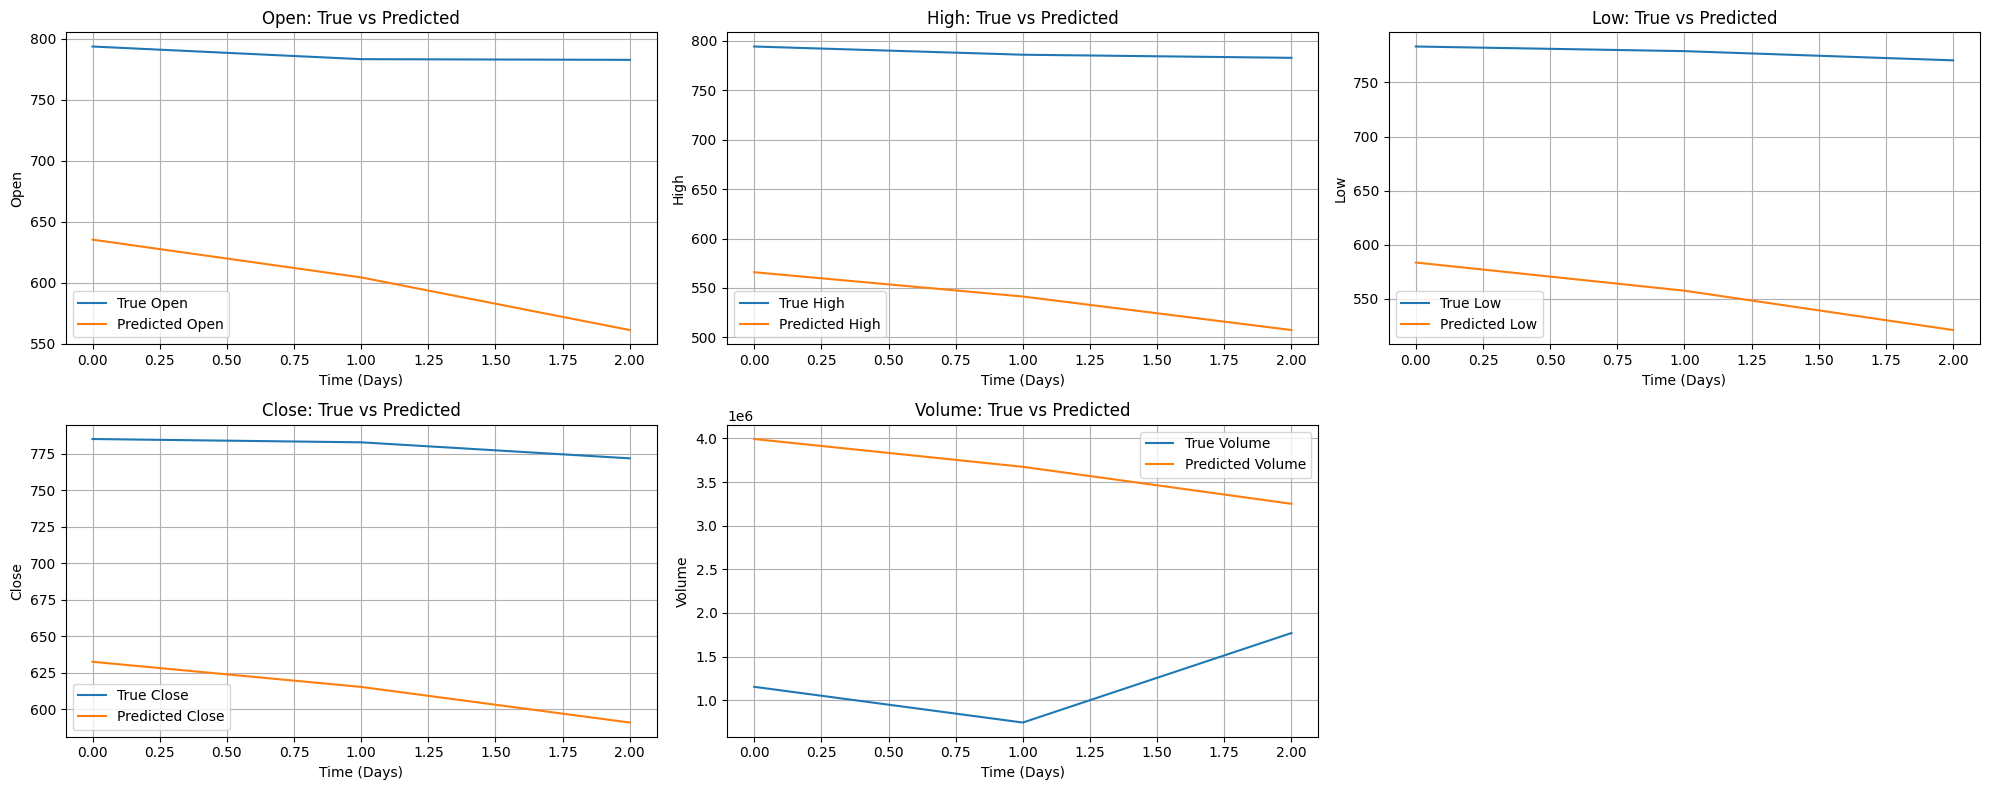

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_06, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_06)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.11690211356686557
Improved GRU RMSE: 0.3419095107873801
Improved GRU MAE: 0.31244311399118285
Improved GRU r^2: -1346.1419761457482


<hr>

### Feature Addition Study 07

In [ ]:
def increased_complexity_gru_07(past_days=training_days, lambda_reg=0.001):
    model = tf.keras.models.Sequential()

    model.add(GRU(units=past_days, activation='tanh', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='tanh', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='tanh', return_sequences=False, kernel_regularizer=l2(lambda_reg)))
    model.add(Dropout(0.2))

    model.add(Dense(units=max(10, int(0.5*past_days))))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_07 = increased_complexity_gru_07()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_07.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_07.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 58ms/step - loss: 2.0162 - mae: 0.2732 - mape: 36036.0977 - val_loss: 0.9539 - val_mae: 0.1010 - val_mape: 63.0017
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.7915 - mae: 0.0601 - mape: 227346.2188 - val_loss: 0.4679 - val_mae: 0.0563 - val_mape: 23.0219
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.4128 - mae: 0.0399 - mape: 18403.3242 - val_loss: 0.2886 - val_mae: 0.0397 - val_mape: 20.9370
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.2618 - mae: 0.0356 - mape: 53215.8789 - val_loss: 0.1942 - val_mae: 0.0657 - val_mape: 27.7928
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.1747 - mae: 0.0403 - mape: 48564.9648 - val_loss: 0.1284 - val_mae: 0.0452 - val_mape: 22.4625
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - loss: 0.1175 - mae: 0.0354 - mape: 31703.8340 - val_loss: 0.0870 - val_mae: 0.0409 - val_mape: 23.5221
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 37ms/step - los

In [ ]:
improved_gru_predictions_07 = predict_future(improved_gru_07, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_06}")

GRU model predicted Future Stock Prices: 
 [[0.6626531  0.531704   0.5803267  0.19491619 0.15960775]
 [0.6050525  0.48582777 0.5309931  0.1712057  0.14684445]
 [0.52477366 0.42248902 0.46212465 0.13762173 0.12988544]]


In [ ]:
rescaled_improved_gru_predictions_07 = train_scaler.inverse_transform(improved_gru_predictions_07)

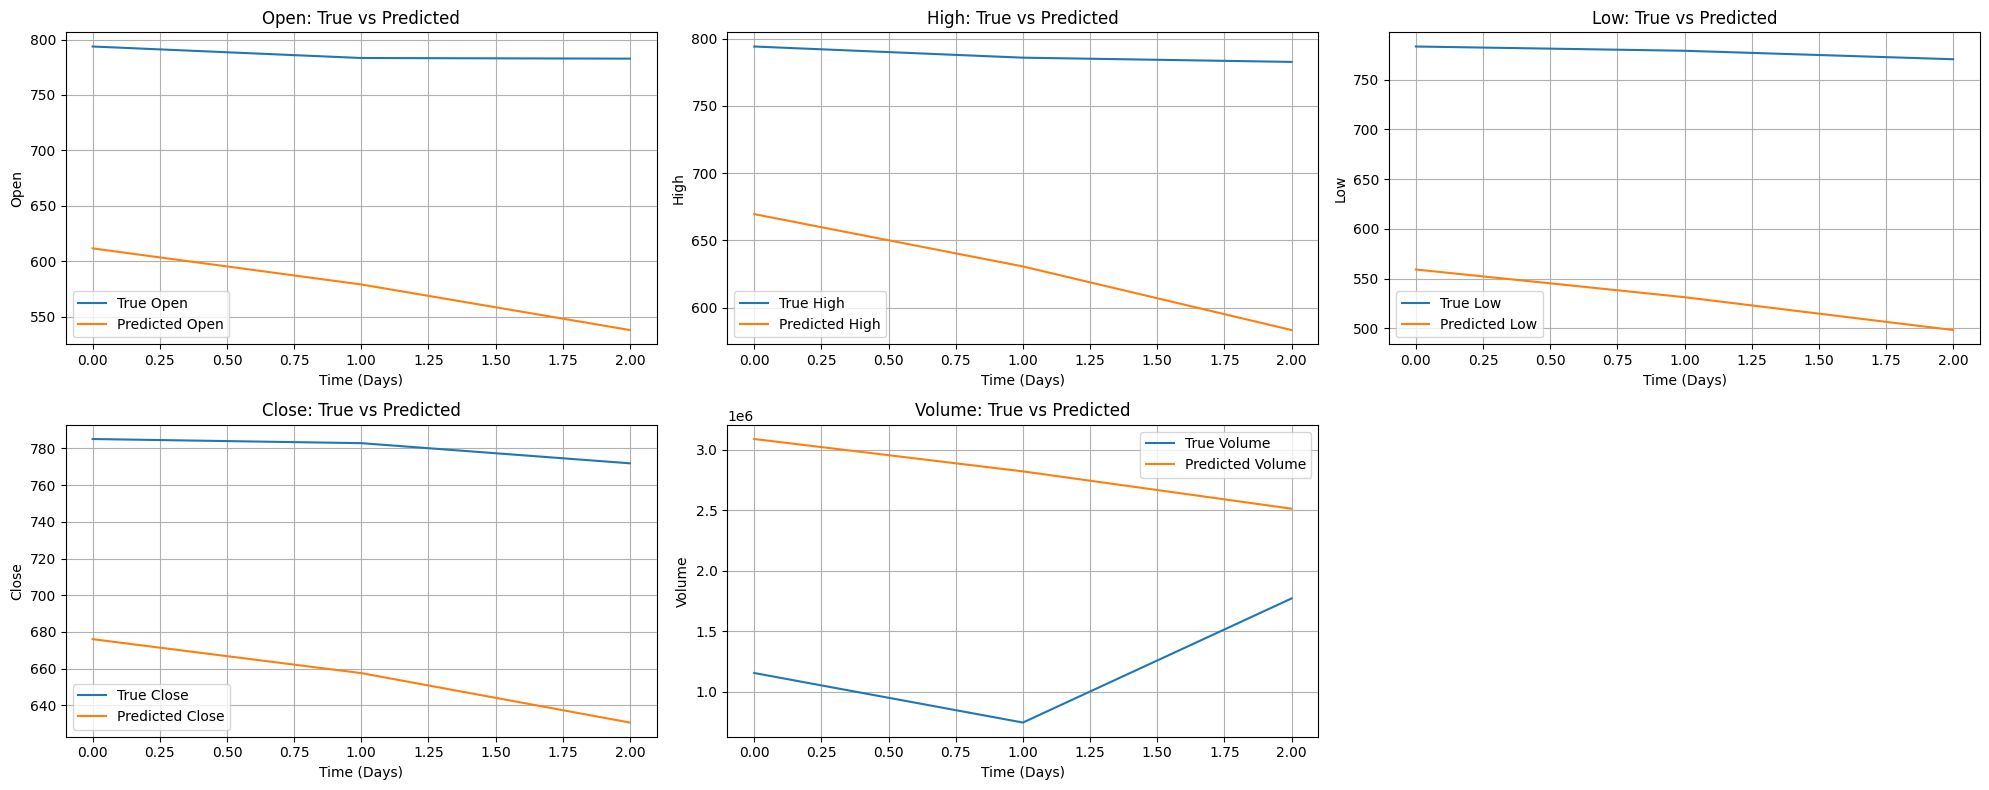

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_07, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_07)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.10084039771941926
Improved GRU RMSE: 0.31755377138276797
Improved GRU MAE: 0.2790056533302484
Improved GRU r^2: -1116.4638865040336


<hr>

### Feature Addition Study 08

In [ ]:
def increased_complexity_gru_08(past_days=training_days):
    model = tf.keras.models.Sequential()

    model.add(GRU(units=past_days, activation='tanh', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='tanh', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='tanh', return_sequences=False))
    model.add(Dropout(0.2))

    model.add(Dense(units=max(10, int(0.5*past_days))))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_08 = increased_complexity_gru_08()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_08.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_08.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 3s 58ms/step - loss: 0.1494 - mae: 0.2889 - mape: 46249.3086 - val_loss: 0.0019 - val_mae: 0.0348 - val_mape: 13.2655
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0061 - mae: 0.0572 - mape: 147753.5312 - val_loss: 0.0060 - val_mae: 0.0556 - val_mape: 65.8862
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033 - mae: 0.0404 - mape: 91619.5312 - val_loss: 0.0015 - val_mae: 0.0307 - val_mape: 8.9074
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 34ms/step - loss: 0.0033 - mae: 0.0372 - mape: 60124.7500 - val_loss: 0.0024 - val_mae: 0.0413 - val_mape: 33.3452
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0024 - mae: 0.0328 - mape: 32745.7656 - val_loss: 0.0029 - val_mae: 0.0472 - val_mape: 12.6089
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 45ms/step - loss: 0.0025 - mae: 0.0354 - mape: 25102.0957 - val_loss: 0.0017 - val_mae: 0.0345 - val_mape: 18.5302
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - loss

In [ ]:
improved_gru_predictions_08 = predict_future(improved_gru_08, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_08}")

GRU model predicted Future Stock Prices: 
 [[0.52363116 0.55500734 0.55633795 0.21795024 0.03685039]
 [0.4281002  0.47601327 0.4741609  0.18028139 0.03638322]
 [0.34769958 0.39170858 0.38163894 0.1416844  0.03493711]]


In [ ]:
rescaled_improved_gru_predictions_08 = train_scaler.inverse_transform(improved_gru_predictions_08)

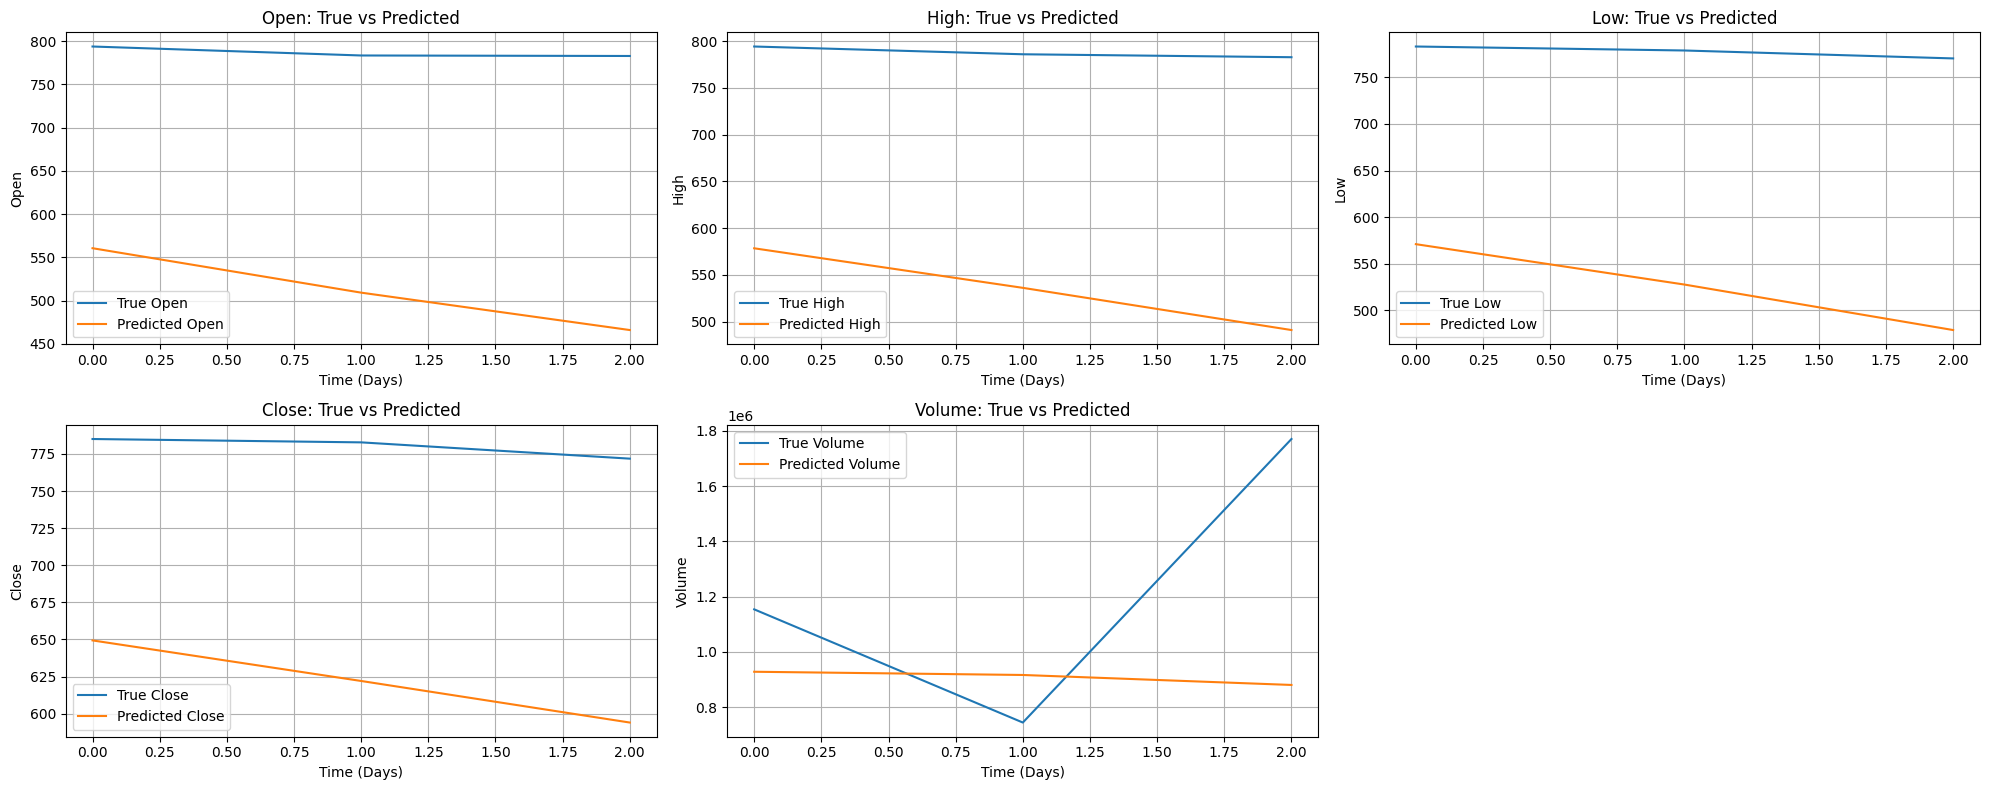

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_08, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_08)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.15410256729745955
Improved GRU RMSE: 0.3925589984925318
Improved GRU MAE: 0.3388865599487762
Improved GRU r^2: -1767.2009529983502


<hr>

### Feature Addition Study 09

In [ ]:
def increased_complexity_gru_09(past_days=training_days):
    model = tf.keras.models.Sequential()

    model.add(GRU(units=past_days, activation='relu', return_sequences=True, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', return_sequences=False, input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(Dense(units=max(10, int(0.5*past_days))))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_09 = increased_complexity_gru_09()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_09.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_09.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 240ms/step - loss: 0.0766 - mae: 0.1918 - mape: 119442.6172 - val_loss: 0.0103 - val_mae: 0.0844 - val_mape: 41.0411
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0048 - mae: 0.0525 - mape: 92865.3359 - val_loss: 0.0026 - val_mae: 0.0433 - val_mape: 21.2169
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0027 - mae: 0.0362 - mape: 21654.5000 - val_loss: 0.0014 - val_mae: 0.0317 - val_mape: 20.0110
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.0025 - mae: 0.0339 - mape: 38456.0078 - val_loss: 5.9253e-04 - val_mae: 0.0194 - val_mape: 12.0808
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - loss: 0.0020 - mae: 0.0301 - mape: 33246.6641 - val_loss: 0.0012 - val_mae: 0.0288 - val_mape: 19.9590
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0020 - mae: 0.0295 - mape: 14671.6943 - val_loss: 7.1572e-04 - val_mae: 0.0204 - val_mape: 19.0314
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/

In [ ]:
improved_gru_predictions_09 = predict_future(improved_gru_09, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_08}")

GRU model predicted Future Stock Prices: 
 [[0.52363116 0.55500734 0.55633795 0.21795024 0.03685039]
 [0.4281002  0.47601327 0.4741609  0.18028139 0.03638322]
 [0.34769958 0.39170858 0.38163894 0.1416844  0.03493711]]


In [ ]:
rescaled_improved_gru_predictions_09 = train_scaler.inverse_transform(improved_gru_predictions_09)

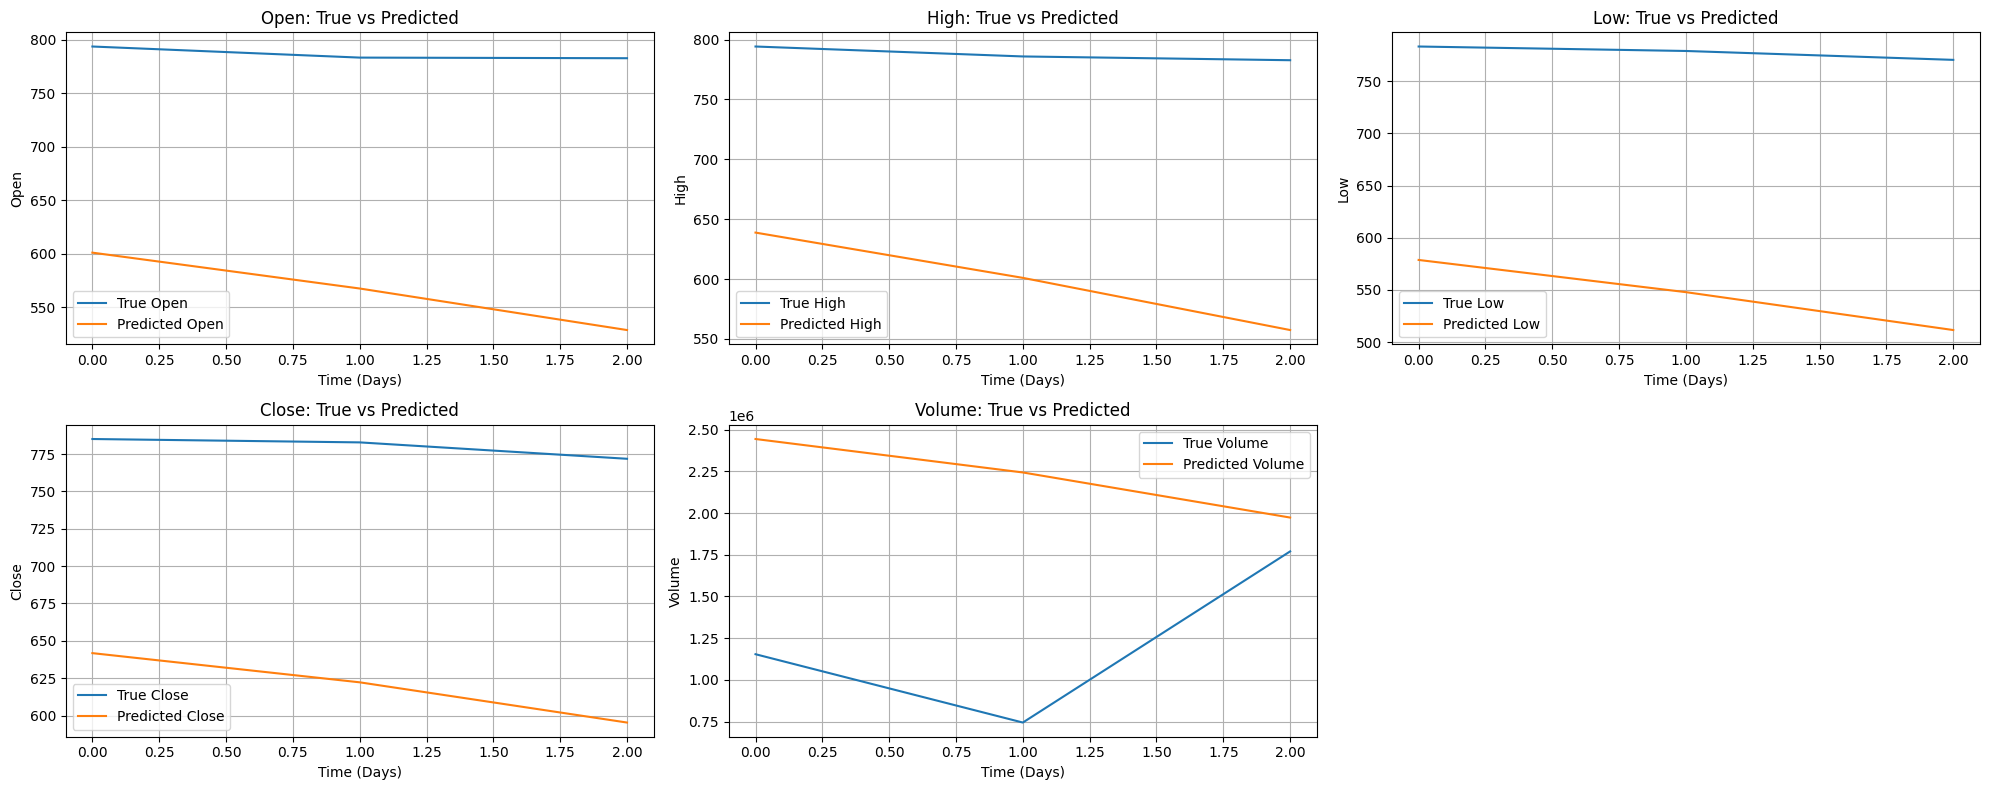

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_09, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_09)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.10863179564548449
Improved GRU RMSE: 0.3295933792500761
Improved GRU MAE: 0.29243763354277796
Improved GRU r^2: -1240.6042536713


<hr>

### Feature Addition Study 10

In [ ]:
def increased_complexity_gru_10(past_days=training_days, lambda_reg=0.001):
    model = tf.keras.models.Sequential()

    model.add(GRU(units=past_days, activation='relu', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', return_sequences=False, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(Dense(units=max(10, int(0.5*past_days))))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_10 = increased_complexity_gru_10()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_10.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_10.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 353ms/step - loss: 0.9588 - mae: 0.1775 - mape: 123795.8359 - val_loss: 0.3161 - val_mae: 0.0430 - val_mape: 47.5775
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - loss: 0.2344 - mae: 0.0479 - mape: 16275.9658 - val_loss: 0.0800 - val_mae: 0.0345 - val_mape: 28.7507
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 42ms/step - loss: 0.0645 - mae: 0.0336 - mape: 26325.9375 - val_loss: 0.0357 - val_mae: 0.0390 - val_mape: 21.9978
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0323 - mae: 0.0342 - mape: 30555.6875 - val_loss: 0.0228 - val_mae: 0.0376 - val_mape: 15.8798
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - loss: 0.0212 - mae: 0.0340 - mape: 56352.8359 - val_loss: 0.0146 - val_mae: 0.0232 - val_mape: 18.3744
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0147 - mae: 0.0310 - mape: 67393.5547 - val_loss: 0.0104 - val_mae: 0.0230 - val_mape: 19.7436
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step - l

In [ ]:
improved_gru_predictions_10 = predict_future(improved_gru_10, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_10}")

GRU model predicted Future Stock Prices: 
 [[0.682782   0.69017184 0.64269507 0.24567592 0.12822711]
 [0.62411493 0.63168335 0.5867191  0.2168568  0.11725824]
 [0.55464095 0.56190795 0.5205474  0.18073365 0.10402139]]


In [ ]:
rescaled_improved_gru_predictions_10 = train_scaler.inverse_transform(improved_gru_predictions_10)

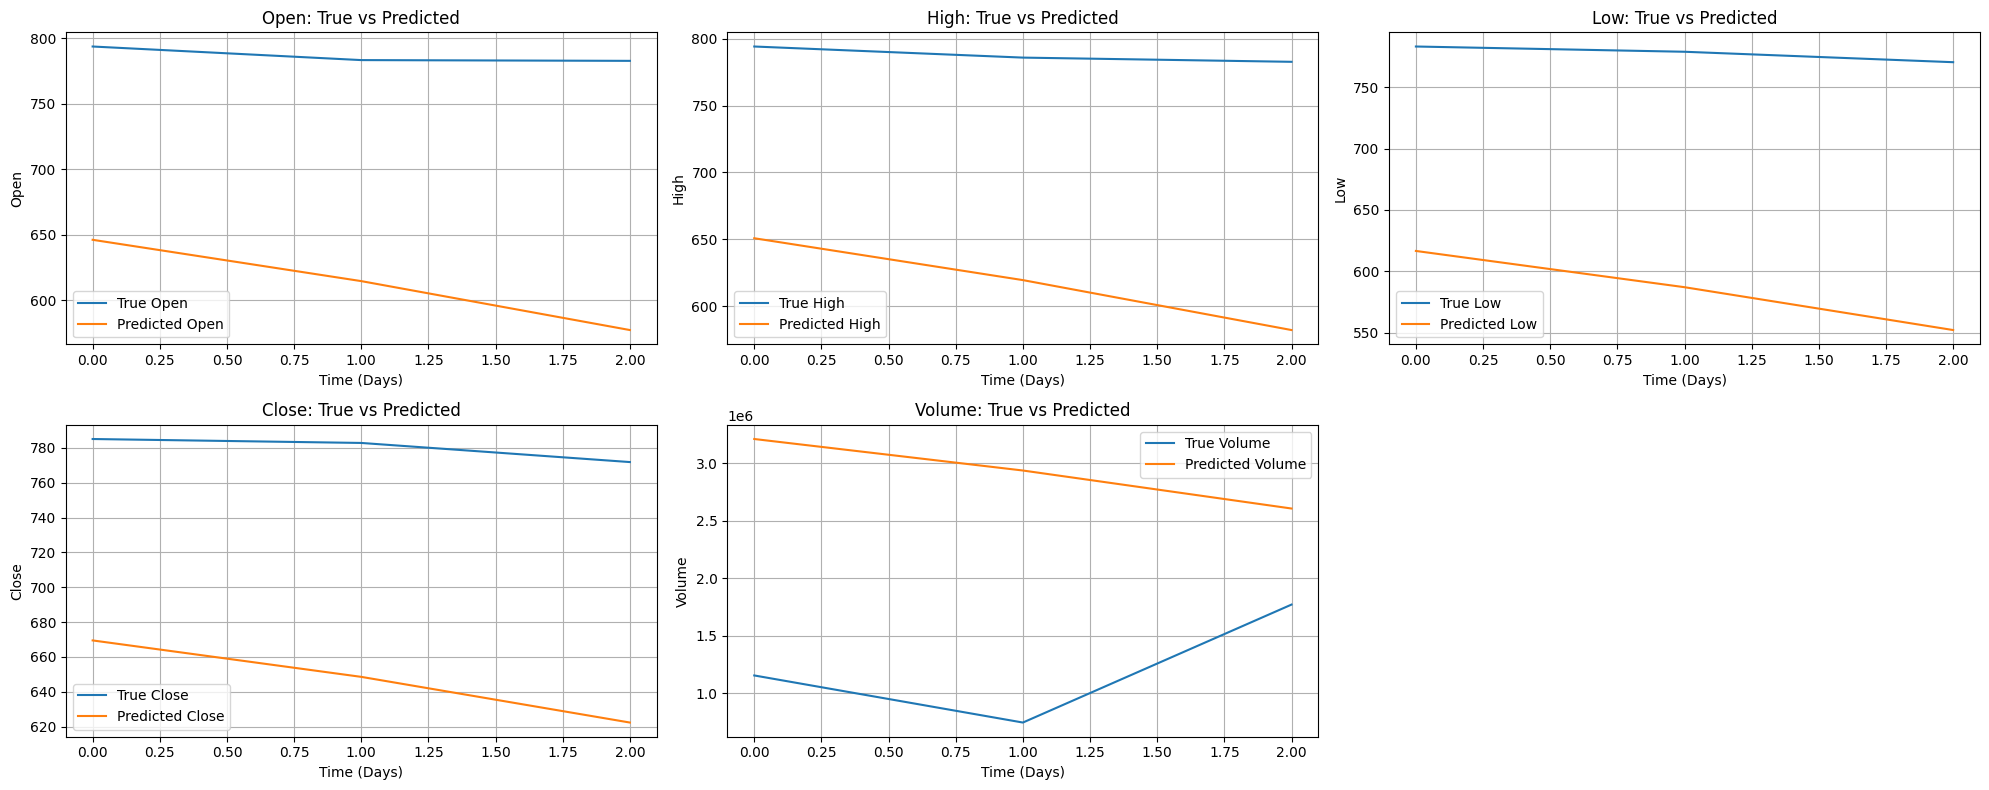

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_10, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_10)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.07663218880776815
Improved GRU RMSE: 0.276825195399133
Improved GRU MAE: 0.25139832960423014
Improved GRU r^2: -871.6003382838953


<hr>

### Feature Addition Study 11

In [ ]:
def increased_complexity_gru_11(past_days=training_days, lambda_reg=0.005):
    model = tf.keras.models.Sequential()

    model.add(GRU(units=past_days, activation='relu', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', return_sequences=False, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(Dense(units=max(10, int(0.5*past_days))))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_11 = increased_complexity_gru_11()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_11.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_11.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 12s 275ms/step - loss: 4.3981 - mae: 0.1716 - mape: 33319.2578 - val_loss: 1.3148 - val_mae: 0.0858 - val_mape: 46.0006
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 44ms/step - loss: 0.9011 - mae: 0.0538 - mape: 77761.8281 - val_loss: 0.1797 - val_mae: 0.0471 - val_mape: 19.2295
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.1205 - mae: 0.0426 - mape: 9101.2158 - val_loss: 0.0285 - val_mae: 0.0310 - val_mape: 19.1547
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0240 - mae: 0.0347 - mape: 14782.0986 - val_loss: 0.0116 - val_mae: 0.0221 - val_mape: 18.2742
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0121 - mae: 0.0355 - mape: 37308.1211 - val_loss: 0.0089 - val_mae: 0.0464 - val_mape: 30.6375
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 41ms/step - loss: 0.0076 - mae: 0.0318 - mape: 47442.3281 - val_loss: 0.0097 - val_mae: 0.0696 - val_mape: 23.3459
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - los

In [ ]:
improved_gru_predictions_11 = predict_future(improved_gru_11, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_11}")

GRU model predicted Future Stock Prices: 
 [[0.62527895 0.64667434 0.6228333  0.14925897 0.11024052]
 [0.568711   0.5885954  0.56717914 0.12471919 0.10051697]
 [0.5025524  0.52031004 0.50151753 0.09512306 0.08879227]]


In [ ]:
rescaled_improved_gru_predictions_11 = train_scaler.inverse_transform(improved_gru_predictions_11)

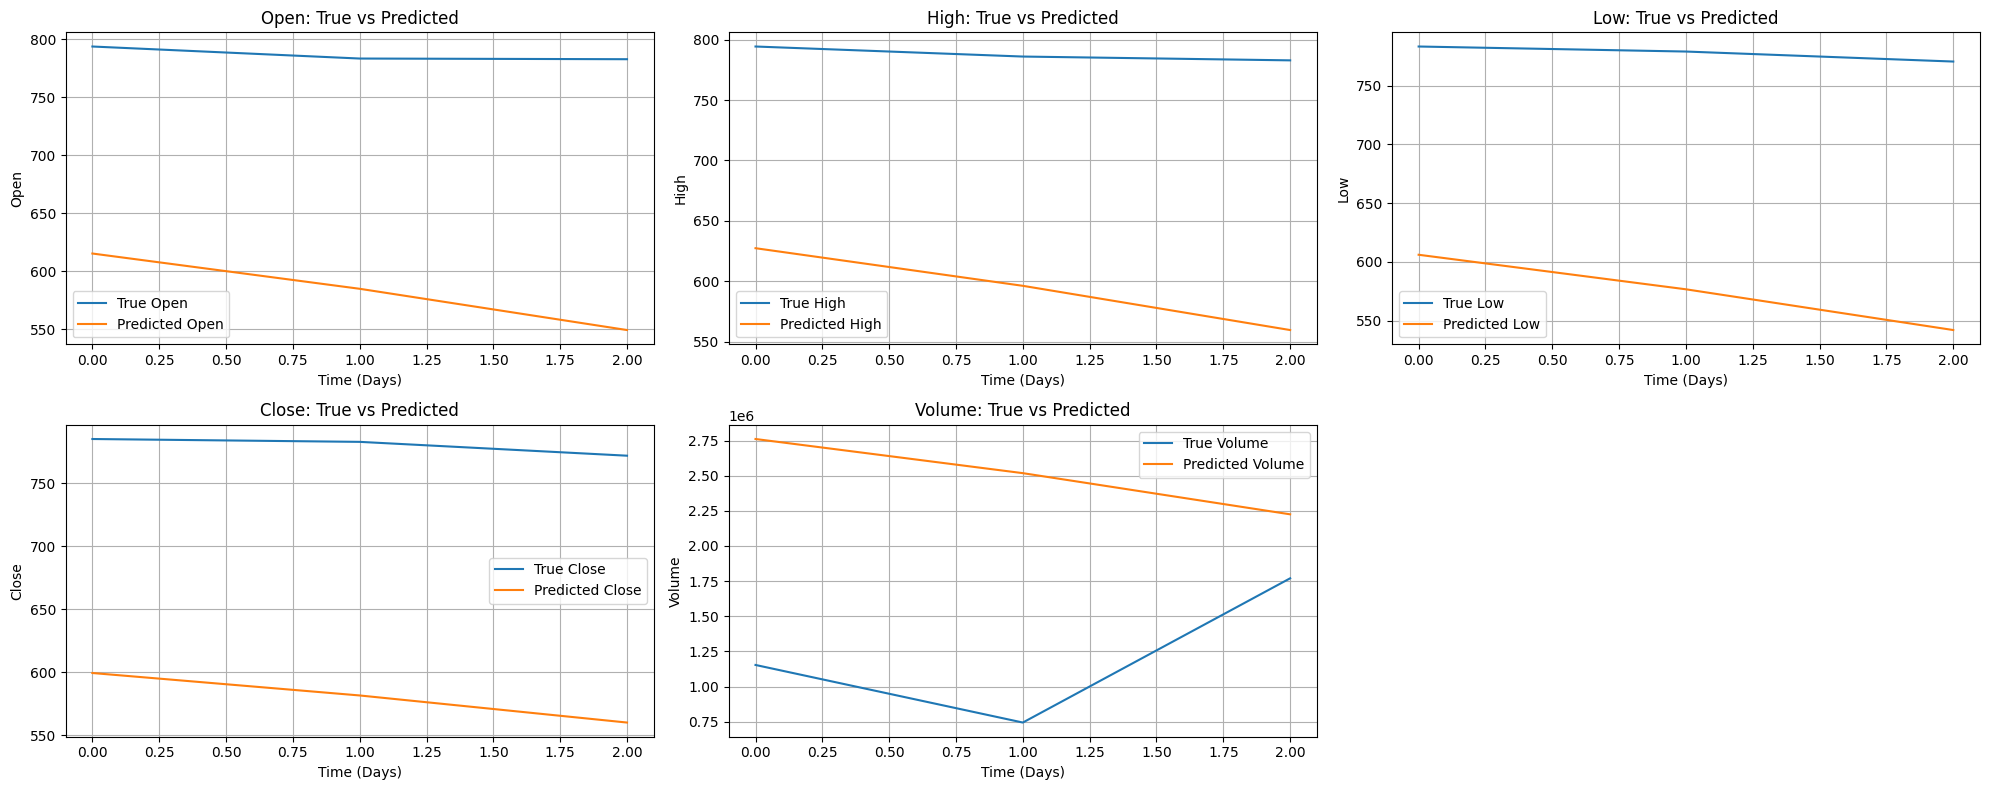

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_11, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_11)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.10094878868957824
Improved GRU RMSE: 0.3177243910838106
Improved GRU MAE: 0.2897862401292342
Improved GRU r^2: -1189.3217829656749


<hr>

### Feature Addition Study 12

In [ ]:
def increased_complexity_gru_12(past_days=training_days, lambda_reg=0.001):
    model = tf.keras.models.Sequential()

    model.add(Bidirectional(GRU(units=past_days, activation='relu', return_sequences=True, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5))))
    model.add(Dropout(0.2))

    model.add(GRU(units=past_days, activation='relu', return_sequences=False, kernel_regularizer=l2(lambda_reg), input_shape=(past_days, 5)))
    model.add(Dropout(0.2))

    model.add(Dense(units=max(10, int(0.5*past_days))))

    model.add(Dense(units=5))
    return model

In [ ]:
improved_gru_12 = increased_complexity_gru_12()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
improved_gru_12.compile(loss='mean_squared_error', optimizer='adam', metrics=['mae', 'mape'])

In [ ]:
improved_gru_12.fit(X_train, y_train, epochs=100, batch_size=32, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 18s 401ms/step - loss: 1.4712 - mae: 0.2033 - mape: 57191.8086 - val_loss: 0.4449 - val_mae: 0.1168 - val_mape: 30.3675
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 11s 68ms/step - loss: 0.3125 - mae: 0.0538 - mape: 27593.5977 - val_loss: 0.1053 - val_mae: 0.0426 - val_mape: 21.0359
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0885 - mae: 0.0384 - mape: 35738.7383 - val_loss: 0.0535 - val_mae: 0.0256 - val_mape: 13.0205
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 77ms/step - loss: 0.0497 - mae: 0.0353 - mape: 47909.7422 - val_loss: 0.0341 - val_mae: 0.0237 - val_mape: 18.3756
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 72ms/step - loss: 0.0321 - mae: 0.0314 - mape: 18538.4395 - val_loss: 0.0226 - val_mae: 0.0170 - val_mape: 9.6573
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 65ms/step - loss: 0.0225 - mae: 0.0323 - mape: 20639.0605 - val_loss: 0.0162 - val_mae: 0.0215 - val_mape: 16.6811
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - lo

In [ ]:
improved_gru_predictions_12 = predict_future(improved_gru_12, new_test_set, prediction_time, training_days)

print(f"GRU model predicted Future Stock Prices: \n {improved_gru_predictions_12}")

GRU model predicted Future Stock Prices: 
 [[0.6154978  0.62189424 0.60814    0.23128252 0.08476497]
 [0.5329869  0.5367672  0.5261929  0.19397855 0.07583106]
 [0.45445138 0.45691454 0.44895497 0.15580747 0.06689909]]


In [ ]:
rescaled_improved_gru_predictions_12 = train_scaler.inverse_transform(improved_gru_predictions_12)

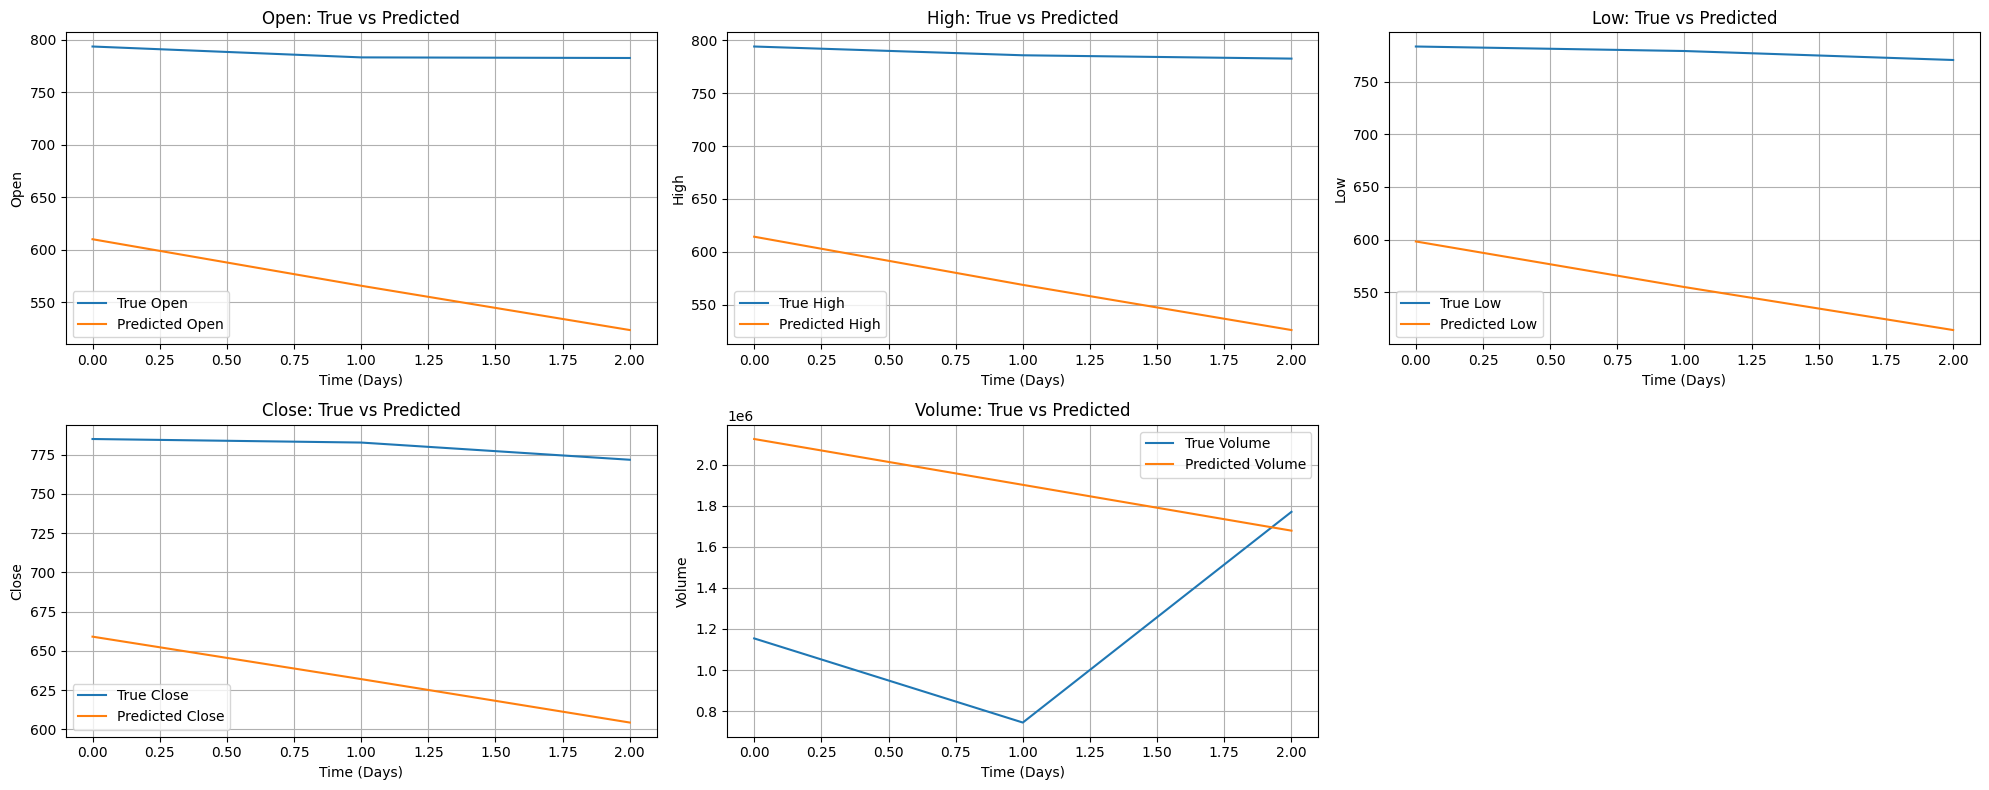

In [ ]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_improved_gru_predictions_12, feature_labels=numerical_features)

In [ ]:
improved_gru_mse, improved_gru_rmse, improved_gru_mae, improved_gru_r2 = evaluate_model(new_test_set, improved_gru_predictions_12)

print(f"Improved GRU MSE: {improved_gru_mse}")
print(f"Improved GRU RMSE: {improved_gru_rmse}")
print(f"Improved GRU MAE: {improved_gru_mae}")
print(f"Improved GRU r^2: {improved_gru_r2}")

Improved GRU MSE: 0.11265784283966081
Improved GRU RMSE: 0.3356454123620056
Improved GRU MAE: 0.29413086562432894
Improved GRU r^2: -1293.999345554703


<hr>

### **Hyperband "Grid Search"**

In [18]:
unit_size = [int(x) for x in [0.5*training_days, 1*training_days, 1.5*training_days, 2*training_days]]
activation = ['tanh', 'relu']
dropout_rate = [0.2, 0.3, 0.4, 0.5]
optimisers = ['adam', 'rmsprop', 'sgd']

In [19]:
def post_addition_gru_model(hp, past_days=training_days):
    model = tf.keras.models.Sequential()

    model.add((GRU(units=hp.Choice('units_1', values=unit_size), activation=hp.Choice('activation_1', values=activation), return_sequences=True, input_shape=(past_days, 5))))
    model.add(Dropout(hp.Choice('dropout_rate_1', values=dropout_rate)))

    model.add(GRU(units=hp.Choice('units_2', values=unit_size), activation=hp.Choice('activation_2', values=activation), return_sequences=True))
    model.add(Dropout(hp.Choice('dropout_rate_2', values=dropout_rate)))

    model.add(GRU(units=hp.Choice('units_3', values=unit_size), activation=hp.Choice('activation_3', values=activation), return_sequences=False))
    model.add(Dropout(hp.Choice('dropout_rate_3', values=dropout_rate)))

    model.add(Dense(units=5))

    model.compile(
    optimizer=hp.Choice('optimizer', values=['adam', 'rmsprop', 'sgd']),
    loss='mean_squared_error',
    metrics=['mae', 'mape']
    )
    return model

In [20]:
post_addition_gru_tuner = kt.Hyperband(
    post_addition_gru_model,
    objective='val_loss',
    max_epochs=25,
    factor=3,
    directory='my_dir',
    project_name='post_addition_gru_hps'
)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [21]:
post_addition_gru_tuner.search(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32)

Trial 30 Complete [00h 00m 34s]
val_loss: 0.0005042795091867447

Best val_loss So Far: 0.00048755150055512786
Total elapsed time: 00h 12m 44s


In [22]:
optimised_gru_hps = post_addition_gru_tuner.get_best_hyperparameters(1)[0]

print("Best Hyperparameters:")
print(f"Units 1: {optimised_gru_hps.get('units_1')}")
print(f"Activation 1: {optimised_gru_hps.get('activation_1')}")
print(f"Dropout Rate 1: {optimised_gru_hps.get('dropout_rate_1')}")
print(f"Units 2: {optimised_gru_hps.get('units_2')}")
print(f"Activation 2: {optimised_gru_hps.get('activation_2')}")
print(f"Dropout Rate 2: {optimised_gru_hps.get('dropout_rate_2')}")
print(f"Units 3: {optimised_gru_hps.get('units_3')}")
print(f"Activation 3: {optimised_gru_hps.get('activation_3')}")
print(f"Dropout Rate 3: {optimised_gru_hps.get('dropout_rate_3')}")
print(f"Optimizer: {optimised_gru_hps.get('optimizer')}")

Best Hyperparameters:
Units 1: 380
Activation 1: tanh
Dropout Rate 1: 0.4
Units 2: 760
Activation 2: tanh
Dropout Rate 2: 0.5
Units 3: 380
Activation 3: relu
Dropout Rate 3: 0.2
Optimizer: adam


In [23]:
optimised_gru_model = post_addition_gru_tuner.hypermodel.build(optimised_gru_hps)

optimised_gru_history = optimised_gru_model.fit(X_train, y_train, validation_split=0.2, epochs=100, batch_size=32, callbacks=[early_stopping])

Epoch 1/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 4s 79ms/step - loss: 0.1321 - mae: 0.2610 - mape: 51529.5938 - val_loss: 0.0325 - val_mae: 0.1627 - val_mape: 28.7918
Epoch 2/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.0098 - mae: 0.0759 - mape: 30840.4316 - val_loss: 0.0022 - val_mae: 0.0369 - val_mape: 35.9813
Epoch 3/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0063 - mae: 0.0602 - mape: 209757.0781 - val_loss: 0.0091 - val_mae: 0.0883 - val_mape: 33.6579
Epoch 4/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step - loss: 0.0048 - mae: 0.0507 - mape: 13774.0244 - val_loss: 0.0018 - val_mae: 0.0363 - val_mape: 20.9679
Epoch 5/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0043 - mae: 0.0478 - mape: 104370.9141 - val_loss: 0.0027 - val_mae: 0.0457 - val_mape: 32.7901
Epoch 6/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 57ms/step - loss: 0.0047 - mae: 0.0505 - mape: 53835.6680 - val_loss: 8.1156e-04 - val_mae: 0.0233 - val_mape: 16.3089
Epoch 7/100
19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step 

In [24]:
optimised_gru_predictions = predict_future(optimised_gru_model, new_test_set, prediction_time, training_days)

print(f"Best GRU model predicted Future Stock Prices: \n {optimised_gru_predictions}")

rescaled_optimised_gru_predictions = train_scaler.inverse_transform(optimised_gru_predictions)

Best GRU model predicted Future Stock Prices: 
 [[0.6546762  0.66443884 0.66708803 0.3553146  0.06897225]
 [0.5976809  0.6067777  0.6086682  0.3160343  0.06737869]
 [0.521463   0.5297609  0.5308691  0.2692971  0.06536509]]


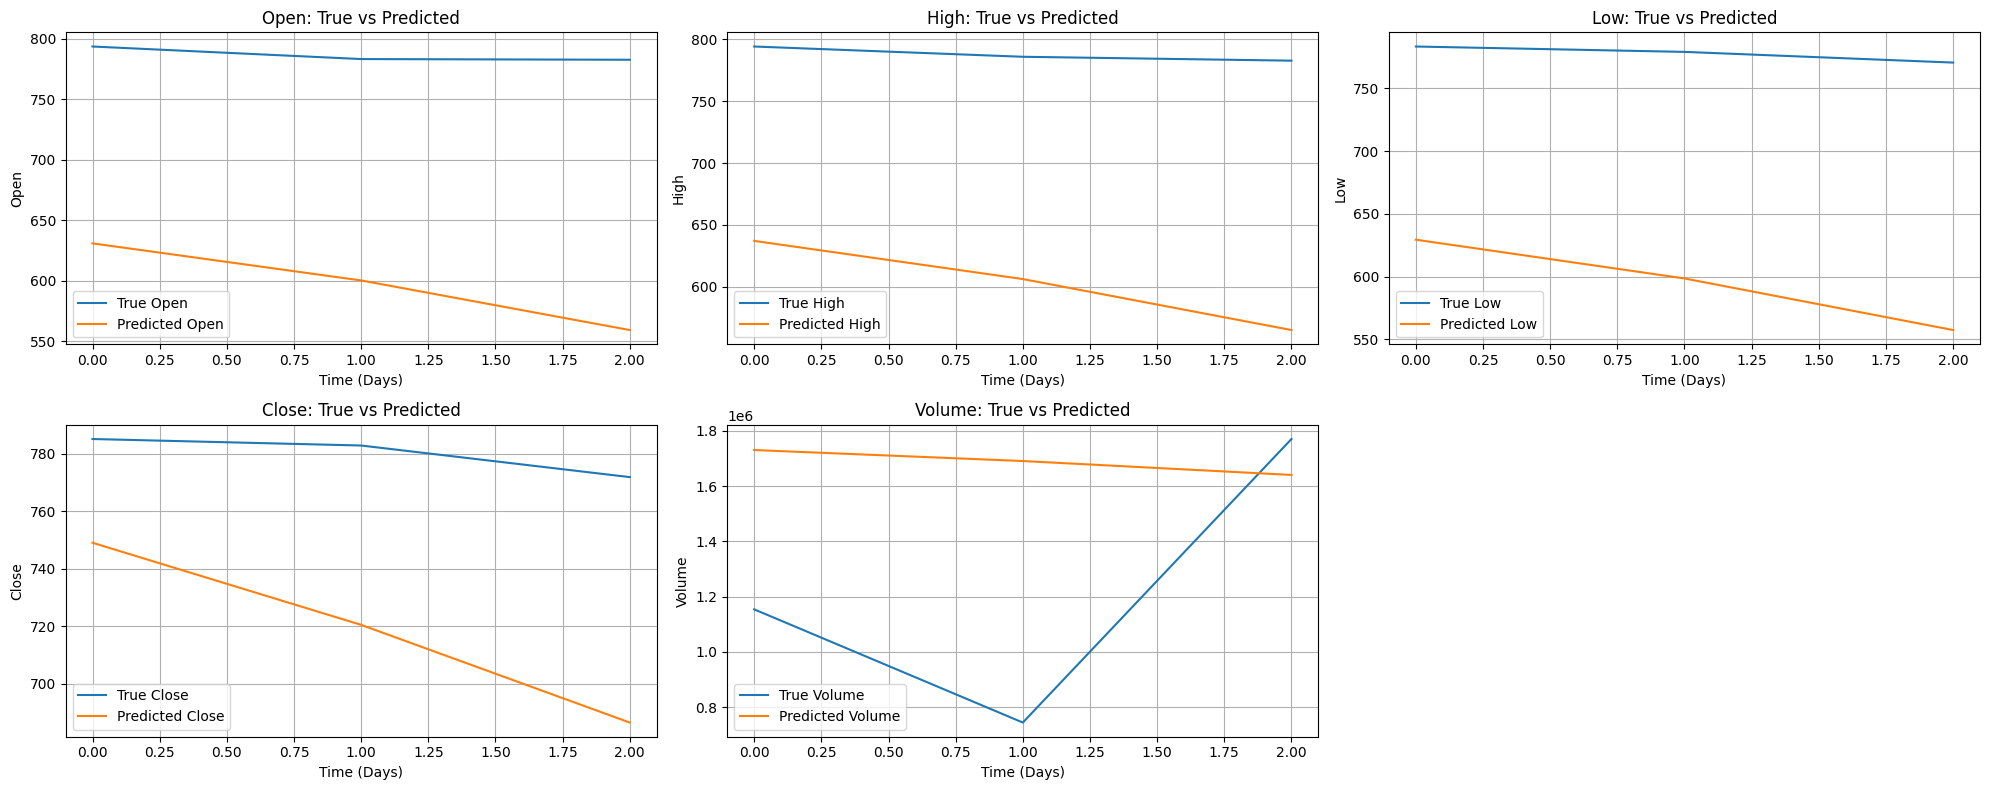

In [25]:
plot_predictions(true_values=rescaled_test, predicted_values=rescaled_optimised_gru_predictions, feature_labels=numerical_features)

In [26]:
hp_gru_mse, hp_gru_rmse, hp_gru_mae, hp_gru_r2 = evaluate_model(new_test_set, optimised_gru_predictions)

print(f"Best GRU MSE: {hp_gru_mse}")
print(f"Best GRU RMSE: {hp_gru_rmse}")
print(f"Best GRU MAE: {hp_gru_mae}")
print(f"Best GRU r-squared: {hp_gru_r2}")

Best GRU MSE: 0.07562720411764438
Best GRU RMSE: 0.27500400745742665
Best GRU MAE: 0.23000342835066764
Best GRU r-squared: -851.8116289641197


In [27]:
data_based_predictions = optimised_gru_model.predict(X_train)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step


In [28]:
rescaled_data_predictions = train_scaler.inverse_transform(data_based_predictions)
rescaled_data = train_scaler.inverse_transform(y_train)

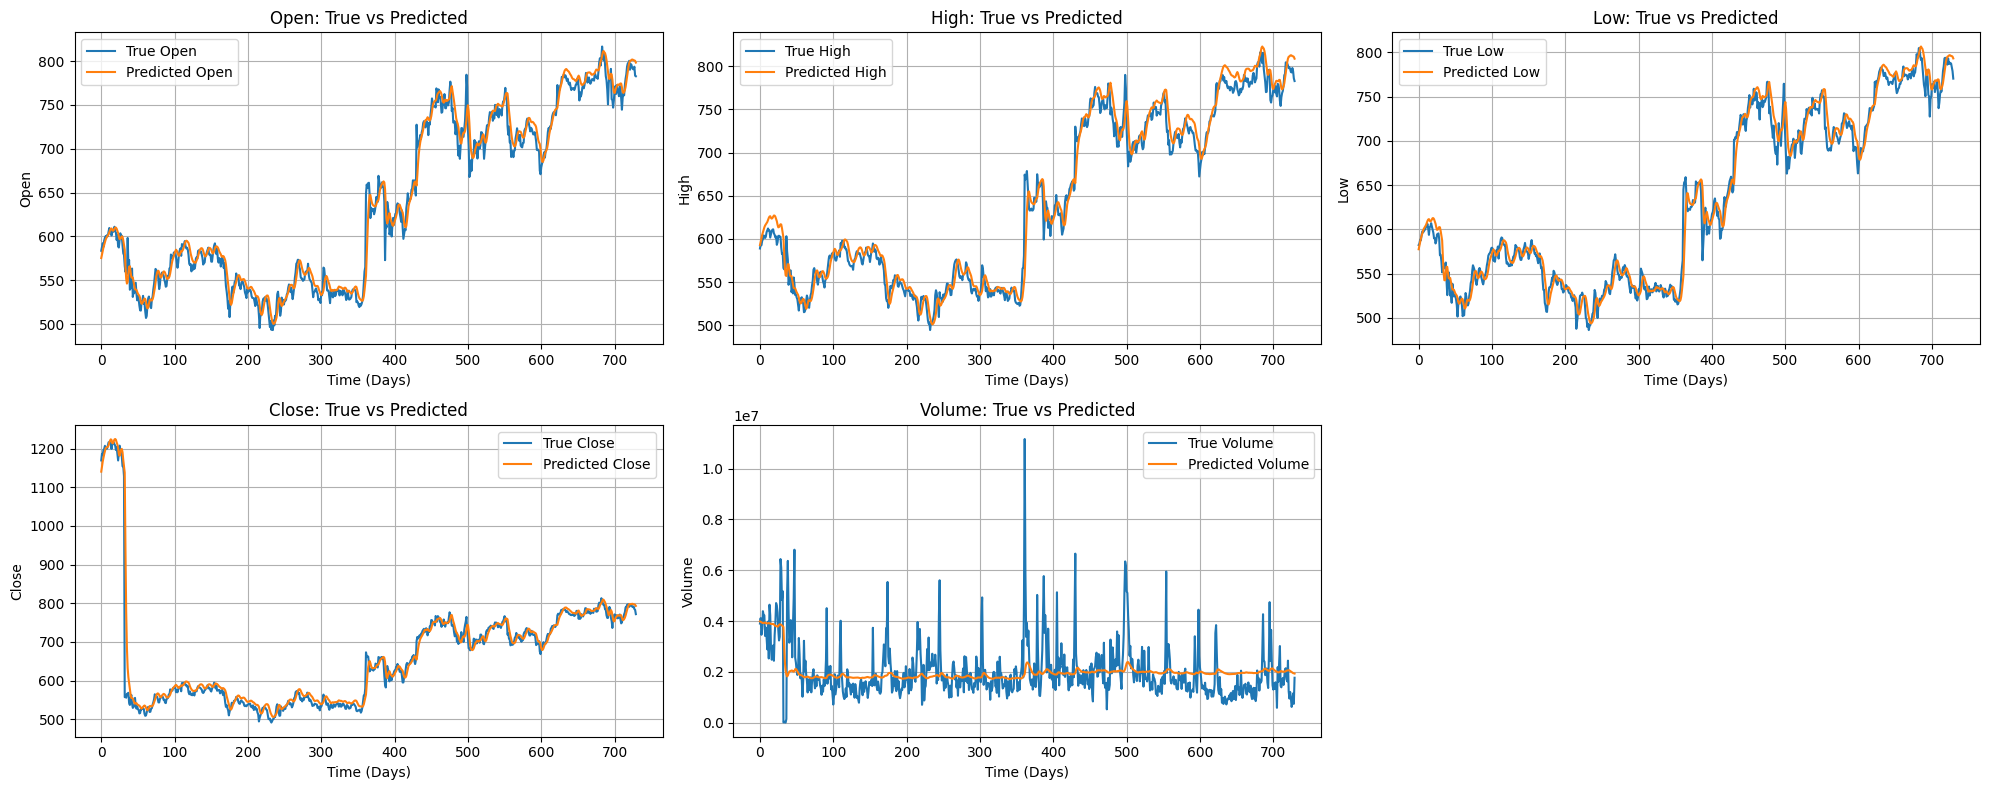

In [29]:
plot_predictions(true_values=rescaled_data, predicted_values=rescaled_data_predictions, feature_labels=numerical_features)

In [30]:
optimised_gru_model.save('/content/drive/MyDrive/Colab Notebooks/Deep Learning Assignment 03/post_addition_gru_model_trained_01.keras')

<hr>

### **The Best GRU Model**

In [ ]:
gru_model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Deep Learning Assignment 03/gru_model.keras')

In [ ]:
gru_data_based_predictions = gru_model.predict(X_train)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step


In [ ]:
gru_rescaled_data_predictions = train_scaler.inverse_transform(gru_data_based_predictions)
rescaled_data = train_scaler.inverse_transform(y_train)

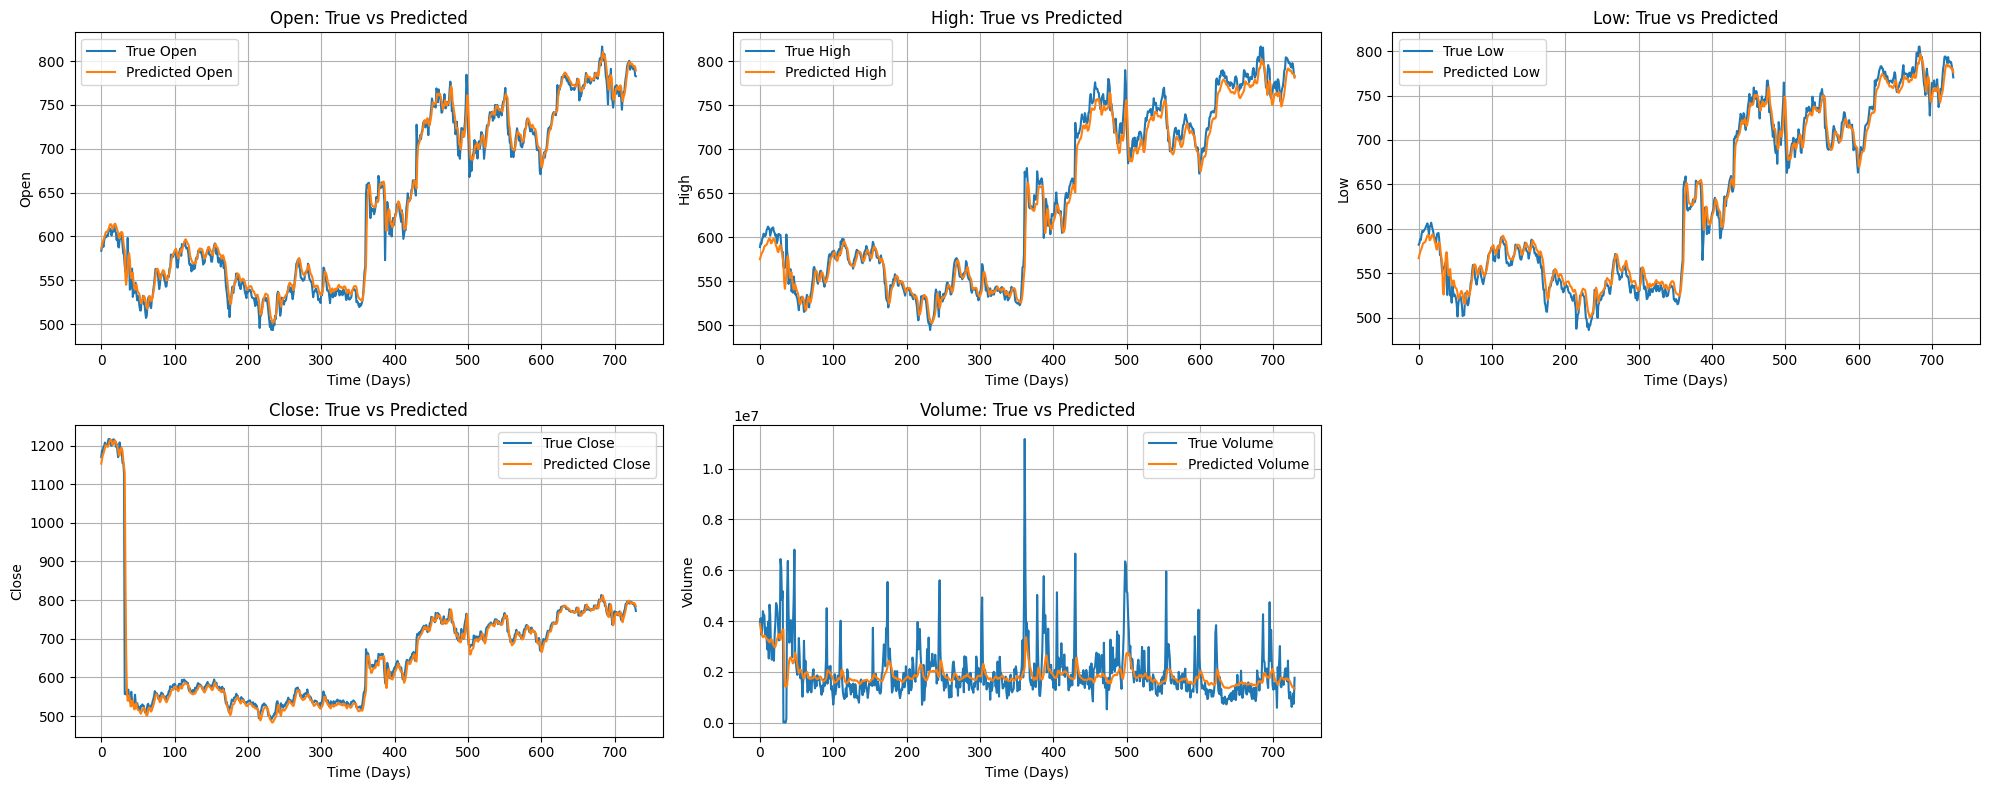

In [ ]:
plot_predictions(true_values=rescaled_data, predicted_values=gru_rescaled_data_predictions, feature_labels=numerical_features)

In [ ]:
gru_future_predictions = predict_future(gru_model, new_test_set, prediction_time, training_days)

print(f"Best GRU model predicted Future Stock Prices: \n {gru_future_predictions}")

Best GRU model predicted Future Stock Prices: 
 [[0.8393349  0.84281814 0.84584004 0.43118832 0.0541843 ]
 [0.795839   0.8015726  0.80288845 0.43080744 0.05674076]
 [0.7492227  0.75454295 0.75627965 0.43666017 0.06104641]]


In [ ]:
print(new_test_set)

[[0.95725128 0.95807422 0.95844067 0.40495845 0.04589107]
 [0.93796041 0.94257381 0.95033338 0.40184391 0.02949139]
 [0.93688146 0.93669113 0.93421352 0.38672602 0.07056868]]


In [ ]:
gru_open_mse, gru_open_rmse, gru_open_mae, gru_open_r2 = evaluate_model(new_test_set[:, 0], gru_future_predictions[:, 0])
gru_high_mse, gru_high_rmse, gru_high_mae, gru_high_r2 = evaluate_model(new_test_set[:, 1], gru_future_predictions[:, 1])
gru_low_mse, gru_low_rmse, gru_low_mae, gru_low_r2 = evaluate_model(new_test_set[:, 2], gru_future_predictions[:, 2])
gru_close_mse, gru_close_rmse, gru_close_mae, gru_close_r2 = evaluate_model(new_test_set[:, 3], gru_future_predictions[:, 3])
gru_volume_mse, gru_volume_rmse, gru_volume_mae, gru_volume_r2 = evaluate_model(new_test_set[:, 4], gru_future_predictions[:, 4])

In [ ]:
print(f"GRU Open MSE: {gru_open_mse}", f"GRU Open RMSE: {gru_open_rmse}", f"GRU Open MAE: {gru_open_mae}", f"GRU Open r-squared: {gru_open_r2}")
print(f"GRU High MSE: {gru_high_mse}", f"GRU High RMSE: {gru_high_rmse}", f"GRU High MAE: {gru_high_mae}", f"GRU High r-squared: {gru_high_r2}")
print(f"GRU Low MSE: {gru_low_mse}", f"GRU Low RMSE: {gru_low_rmse}", f"GRU Low MAE: {gru_low_mae}", f"GRU Low r-squared: {gru_low_r2}")
print(f"GRU Close MSE: {gru_close_mse}", f"GRU Close RMSE: {gru_close_rmse}", f"GRU Close MAE: {gru_close_mae}", f"GRU Close r-squared: {gru_close_r2}")
print(f"GRU Volume MSE: {gru_volume_mse}", f"GRU Volume RMSE: {gru_volume_rmse}", f"GRU Volume MAE: {gru_volume_mae}", f"GRU Volume r-squared: {gru_volume_r2}")

GRU Open MSE: 0.02310619288115918 GRU Open RMSE: 0.15200721325371103 GRU Open MAE: 0.14923218301646105 GRU Open r-squared: -262.8257695824581
GRU High MSE: 0.02211442002163209 GRU High RMSE: 0.14870917934556727 GRU High MAE: 0.14613515044084455 GRU High r-squared: -270.85972835843984
GRU Low MSE: 0.022026457629457662 GRU Low RMSE: 0.14841313159372949 GRU Low MAE: 0.1459931455495749 GRU Low r-squared: -216.23932433214895
GRU Close MSE: 0.0013401037841550758 GRU Close RMSE: 0.03660742799153029 GRU Close MAE: 0.035042514982624784 GRU Close r-squared: -20.134589076611054
GRU Volume MSE: 0.0003006598534241453 GRU Volume RMSE: 0.01733954594054139 GRU Volume MAE: 0.01502162429391582 GRU Volume r-squared: -0.054832503965138946
